In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time

# Load Input Data:

In [2]:
vot_pdf = np.genfromtxt('../original_code/VOT_distr.csv', delimiter=',')[1:]
vots = []
vot_p = []
for row in vot_pdf:
    vots.append(row[0])
    vot_p.append(row[1])
print(vot_p)
print()
vot_p=vot_p/np.sum(vot_p)
print(vot_p)

[0.01, 0.02, 0.01, 0.02, 0.02, 0.02, 0.02, 0.04, 0.02, 0.07, 0.02, 0.07, 0.16, 0.13, 0.05, 0.25, 0.03, 0.05]

[0.00990099 0.01980198 0.00990099 0.01980198 0.01980198 0.01980198
 0.01980198 0.03960396 0.01980198 0.06930693 0.01980198 0.06930693
 0.15841584 0.12871287 0.04950495 0.24752475 0.02970297 0.04950495]


# Travel time functions:

In [3]:
###### BPR Parameters ###### 
bpr_true_capacity = 66
bpr_true_fftt = 60*22/67
bpr_true_alpha = 0.2

def true_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, alpha = bpr_true_alpha):
    """
    Find the (exact) travel time on an edge given an edge flow
    """

    return fftt * (1+alpha*(flow_val/capacity)**6)

###### Approximation Parameters ###### 
const_multiplier = 1
cap_thresh_multiplier = 0.7835
apx_slope = 0.314

def apx_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, 
                a = const_multiplier, cap_thresh = cap_thresh_multiplier, b = apx_slope):
    """
    Find the (approximate) travel time on an edge given an edge flow
    """
    
    if flow_val <= cap_thresh*capacity:
        return a*fftt
    else:
        return a*fftt + b*(flow_val - cap_thresh*capacity)

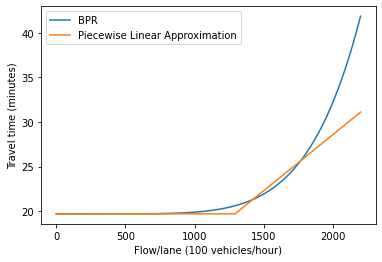

In [4]:
###### Check plots of BPR and approximation ###### 
multiplier = 100/4 # converts from 100 vehicles/hour --> vehicle/hour per lane

x =  np.linspace(0,int(np.round(88*multiplier,0)),int(np.round(89*2*multiplier,0)))
y = [true_bpr_cost(i, capacity = bpr_true_capacity*multiplier) for i in x]

plt.plot(x, y,label='BPR')

y_apx = [apx_bpr_cost(i,capacity = bpr_true_capacity*multiplier, b = apx_slope/multiplier) for i in x]

plt.plot(x, y_apx,label='Piecewise Linear Approximation')
plt.xlabel("Flow/lane (100 vehicles/hour)")
plt.ylabel("Travel time (minutes)")
plt.legend(loc='upper left')

# Generate Demand Profile:

In [5]:
###### Specify parameters for problem ###### 
T = 5 # Time Horizon
tau_arr = 20*np.linspace(0, 1, 21)[0:] # Toll discretization
print('Tau:\n {}'.format(tau_arr))
print()

B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 
print('B:\n {}'.format(B_arr))
print()

num_total = 8000 # number of users
num_eligible =int( num_total*.17) # number of eligible users
num_ineligible = num_total-num_eligible # number of ineligible users

###### VoT information ###### 
vot_all = np.sort(np.round(np.random.choice(vots, size = num_total, p=vot_p),2)/60) # generate baseline VoT for all users
vot_all_days = np.empty(shape=(num_total,T)) 
count=0
for v in vot_all:
    if count < num_eligible:
        vot_all_days[count,:]=[v for t in range(T)] # VoT of eligible users does not vary over time periods
    else:
        vot_all_days[count,:]=list((1+0.25*(np.random.random_sample(size=T)-0.5))*v) # VoT of ineligible users varies over time periods
    count+=1
    
vot_eligible = vot_all_days[:num_eligible,:]
vot_ineligible= vot_all_days[num_eligible:,:]

print('Eligible vot range:\n {} ({} $/hr), {} ({} $/hr)'.format(np.min(vot_eligible),60*np.min(np.round(vot_eligible,2)),np.max(np.round(vot_eligible,2)),60*np.max(np.round(vot_eligible,2))))
print()
print('Ineligible vot range:\n {}({} $/hr), {} ({} $/hr)'.format(np.min(np.round(vot_ineligible,2)),60*np.min(np.round(vot_ineligible,2)),np.max(np.round(vot_ineligible,2)),60*np.max(np.round(vot_ineligible,2))))
print()
print('Mean vot:\n {} $/hr; median: {} $/hr'.format(60*np.round(np.mean(vot_all_days),2),60*np.round(np.median(vot_all_days),2)))

Tau:
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]

B:
 [ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
 90.]

Eligible vot range:
 0.02 (1.2 $/hr), 0.24 (14.399999999999999 $/hr)

Ineligible vot range:
 0.21(12.6 $/hr), 2.7 (162.0 $/hr)

Mean vot:
 44.4 $/hr; median: 37.2 $/hr


Text(0, 0.5, '% of population')

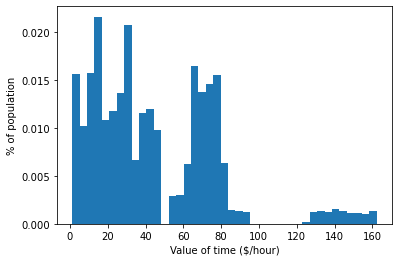

In [6]:
###### Check VoT distribution ###### 
plt.hist(vot_all_days.flatten()*60,bins=41,density=True)
plt.xlabel("Value of time ($/hour)")
plt.ylabel("% of population")

# Define Social Objectives of Interest:

In [48]:
###### Estimate VoT percentiles for ineligible group ###### 
percentiles = {}
thresh = 10
for p in range(11):
    print(np.round(np.percentile(vot_ineligible,p*10)*60,2))
    percentiles[p*10]=np.percentile(vot_ineligible,p*10)*60

12.62
18.55
23.56
30.04
37.1
43.87
63.47
68.64
74.59
79.96
162.24


In [49]:
print("vot_ineligible:", vot_ineligible)
print()
print("percentiles:", percentiles)

vot_ineligible: [[0.22104101 0.2330959  0.24162655 0.22831559 0.25898016]
 [0.25821007 0.24431969 0.24704861 0.23752714 0.23333858]
 [0.25001435 0.24031134 0.23011159 0.22853288 0.22327205]
 ...
 [2.25780327 2.60784197 2.45921476 2.65756329 2.45747647]
 [2.24362963 2.36446338 2.57008366 2.54071393 2.27977451]
 [2.2117726  2.33534495 2.69871032 2.67228707 2.31955422]]

percentiles: {0: 12.617896787888677, 10: 18.54778263863191, 20: 23.561714833991424, 30: 30.036652594085695, 40: 37.10036243763742, 50: 43.87414623167377, 60: 63.470572908334205, 70: 68.64407251020874, 80: 74.5929869850944, 90: 79.96414075334945, 100: 162.23865006201817}


# Evaluation Metrics:

In [137]:
###### Evaluate Travel Time Metrics ###### 
def evaluate_avg_tt_in_budget(solution_, demand_multiplier):
    """
    Average travel time, ineligible only
    """
    
    ineligible_tt = sum( (solution_['users_in'][i, 0, t] + solution_['users_in'][i, 1, t]) * apx_bpr_cost(solution_['edge_flows'][0, t],
                                                                    capacity = bpr_true_capacity * demand_multiplier[0],
                                                                    b = apx_slope / demand_multiplier[0])
                                 for i in range(num_ineligible) for t in range(T))/(T * num_ineligible)
    ineligible_tt += sum( solution_['users_in'][i, 2, t] * apx_bpr_cost(solution_['edge_flows'][1, t],
                                                                    capacity = bpr_true_capacity * demand_multiplier[1],
                                                                    b = apx_slope / demand_multiplier[1])
                                 for i in range(num_ineligible) for t in range(T))/(T * num_ineligible)
    
    
    print()
    print("ineligible_total_time:", sum( (solution_['users_in'][i, 0, t] + solution_['users_in'][i, 1, t]) * apx_bpr_cost(solution_['edge_flows'][0, t],
                                                                    capacity = bpr_true_capacity * demand_multiplier[0],
                                                                    b = apx_slope / demand_multiplier[0])
                                 for i in range(num_ineligible) for t in range(T)) \
         + sum( solution_['users_in'][i, 2, t] * apx_bpr_cost(solution_['edge_flows'][1, t],
                                                                    capacity = bpr_true_capacity * demand_multiplier[1],
                                                                    b = apx_slope / demand_multiplier[1])
                                 for i in range(num_ineligible) for t in range(T)))
    print("T:", T)
    print("num_ineligible:", num_ineligible)
    print("ineligible_average_time (ineligible_tt):", ineligible_tt)
    for t in range(T):
        print("t:", t)
        print("solution_['edge_flows'][0, t]:", solution_['edge_flows'][0, t])
        print("solution_['edge_flows'][1, t]:", solution_['edge_flows'][1, t])
    print()
    
    return ineligible_tt

def evaluate_avg_tt_el_budget(solution_, demand_multiplier):
    """
    Average travel time, eligible only
    """
    
    ## Frank: Not sure why, in the original code, one needs to divide by num_eligible twice.
    # I have removed them for now
    
    # Express lane:
    eligible_tt = sum(( (solution_['users_el'][0, t] + solution_['users_el'][1, t]))*apx_bpr_cost(solution_['edge_flows'][0, t],
                                                               capacity = bpr_true_capacity * demand_multiplier[0],
                                                               b = apx_slope / demand_multiplier[0])
                                for t in range(T)) /(T * num_eligible)
    
    # General-purpose lane:
    eligible_tt += sum((solution_['users_el'][2, t])*apx_bpr_cost(solution_['edge_flows'][1, t],
                                                               capacity = bpr_true_capacity * demand_multiplier[1],
                                                               b = apx_slope / demand_multiplier[1])
                                for t in range(T)) /(T * num_eligible)
    
    print()
    print("eligible_total_time:", sum(( (solution_['users_el'][0, t] + solution_['users_el'][1, t]))*apx_bpr_cost(solution_['edge_flows'][0, t],
                                                               capacity = bpr_true_capacity * demand_multiplier[0],
                                                               b = apx_slope / demand_multiplier[0])
                                for t in range(T)) \
         + sum((solution_['users_el'][2, t])*apx_bpr_cost(solution_['edge_flows'][1, t],
                                                               capacity = bpr_true_capacity * demand_multiplier[1],
                                                               b = apx_slope / demand_multiplier[1])
                                for t in range(T)) )
    print("T:", T)
    print("num_eligible:", num_eligible)
    print("eligible_average_time (eligible_tt):", eligible_tt)
    for t in range(T):
        print("t:", t)
        print("solution_['edge_flows'][0, t]:", solution_['edge_flows'][0, t])
        print("solution_['edge_flows'][1, t]:", solution_['edge_flows'][1, t])
    print()
    
    return eligible_tt

def evaluate_total_tt_budget(solution_,demand_multiplier):
    """
    Total travel time
    """
    ineligible_tt = evaluate_avg_tt_in_budget(solution_, demand_multiplier) * num_ineligible * T
    eligible_tt = evaluate_avg_tt_el_budget(solution_, demand_multiplier) * num_eligible * T
    
    return eligible_tt + ineligible_tt

def evaluate_avg_travel_time_budget(solution_,demand_multiplier):
    """
    Average travel time
    """
    return evaluate_total_tt_budget(solution_,demand_multiplier)/(T*num_total)

def evaluate_avg_express_tt_budget(solution_,demand_multiplier):
    """
    Average travel time on express lane
    """
    avg_EL_tt = sum(apx_bpr_cost(solution_['edge_flows'][0, t],capacity = bpr_true_capacity*demand_multiplier[0],
                                 b = apx_slope/demand_multiplier[0]) for t in range(T))/T
    return avg_EL_tt

def evaluate_avg_general_tt_budget(solution_,demand_multiplier):
    """
    Average travel time on general purpose lanes
    """
    avg_GP_tt = sum(apx_bpr_cost(solution_['edge_flows'][1, t],capacity = bpr_true_capacity*demand_multiplier[1],
                                 b = apx_slope/demand_multiplier[1]) for t in range(T))/T
    return avg_GP_tt
    
def evaluate_avg_tt_savings_budget(solution_,demand_multiplier):
    """
    Average travel time savings   
    """
    delta_tt = sum(apx_bpr_cost(solution_['edge_flows'][1, t],capacity = bpr_true_capacity*demand_multiplier[1],
                                 b = apx_slope/demand_multiplier[1]) - 
                   apx_bpr_cost(solution_['edge_flows'][0, t],capacity = bpr_true_capacity*demand_multiplier[0],
                                b = apx_slope/demand_multiplier[0]) for t in range(T))/T
    return delta_tt


###### Evaluate Lane Usage Metrics ###### 
def evaluate_express_usage_budget(solution_,demand_multiplier):
    """
    Average share of all/el/inel users using express lane
    """
    share_eligible = sum( (solution_['users_el'][0, t] + solution_['users_el'][1, t]) for t in range(T))/(T * num_eligible)
    share_ineligible = sum((solution_['users_in'][i, 0, t] + solution_['users_in'][i, 1, t])  for i in range(num_ineligible) for t in range(T))/(T * num_ineligible)
    share_all = (sum(solution_['users_el'][0, t] for t in range(T)) +
               sum(solution_['users_in'][i, 0, t] for i in range(num_ineligible) for t in range(T)) +
                sum(solution_['users_el'][1, t] for t in range(T)) +
               sum(solution_['users_in'][i, 1, t] for i in range(num_ineligible) for t in range(T)) )/(T * num_total)
    
    return share_all, share_eligible, share_ineligible


def evaluate_express_usage_percentile_inel_budget(solution_,demand_multiplier,percentiles):
    share_ineligible = {}
    for p,thresh in percentiles.items():
        # number of ineligible users in the group
        if p >= 10:
            these_ineligible = sum(len(np.where((vot_ineligible[:,t]<=(thresh/60))&
                                                (vot_ineligible[:,t]>(percentiles[p-10]/60)))[0]) for t in range(T))
        else:
            these_ineligible = sum(len(np.where((vot_ineligible[:,t]<=(thresh/60)))[0]) for t in range(T))
        
        share_ineligible[p] = 0
        for t in range(T):
            if p>=10:
                share_ineligible[p]+=sum( (solution_['users_in'][i, 0, t] + solution_['users_in'][i, 1, t]) 
                                         for i in np.where((vot_ineligible[:,t]<=(thresh/60))&
                                                           (vot_ineligible[:,t]>(percentiles[p-10]/60)))[0])
            else:
                share_ineligible[p]+=sum( (solution_['users_in'][i, 0, t] + solution_['users_in'][i, 1, t])
                                         for i in np.where((vot_ineligible[:,t]<=(thresh/60)))[0])
        if these_ineligible > 0:
            share_ineligible[p]=share_ineligible[p]/these_ineligible
#         print("p:", p)
#         print("share_ineligible[p]:", share_ineligible[p])
#         print("these_ineligible:", these_ineligible)
    
    return share_ineligible


###### Evaluate Travel Cost Metrics ###### 
def evaluate_total_travel_cost_in_budget(solution_, tau, demand_multiplier):
    
    """
    Total travel cost for ineligible only
    """
    
    ineligible_travel_cost = sum((solution_['users_in'][i, 0, t] + solution_['users_in'][i, 1, t]) * vot_ineligible[i, t]*apx_bpr_cost(solution_['edge_flows'][0, t],
                                                                                                  capacity = bpr_true_capacity*demand_multiplier[0],
                                                                                                  b = apx_slope/demand_multiplier[0])
                                 for i in range(num_ineligible) for t in range(T))
    ineligible_travel_cost += sum(solution_['users_in'][i, 2, t]*vot_ineligible[i, t]*apx_bpr_cost(solution_['edge_flows'][1, t],
                                                                                                  capacity = bpr_true_capacity*demand_multiplier[1],
                                                                                                  b = apx_slope/demand_multiplier[1])
                                 for i in range(num_ineligible) for t in range(T))
    
    toll_revenue_in = evaluate_total_revenue_in_budget(solution_, tau, demand_multiplier)
    return ineligible_travel_cost + toll_revenue_in


def evaluate_total_travel_cost_el_budget(solution_, tau, demand_multiplier):
    
    """
    Total travel cost for eligible only
    """
    
    eligible_travel_cost = sum(( (solution_['users_el'][0, t] + solution_['users_el'][1, t]) /num_eligible)*vot_eligible[i, t]*apx_bpr_cost(solution_['edge_flows'][0, t],
                                                                                                           capacity = bpr_true_capacity*demand_multiplier[0],
                                                                                                           b = apx_slope/demand_multiplier[0])  
                               for i in range(num_eligible) for t in range(T))
    
    eligible_travel_cost += sum((solution_['users_el'][2, t]/num_eligible)*vot_eligible[i, t]*apx_bpr_cost(solution_['edge_flows'][1, t],
                                                                                                           capacity = bpr_true_capacity*demand_multiplier[1],
                                                                                                           b = apx_slope/demand_multiplier[1])  
                               for i in range(num_eligible) for t in range(T))
    
    toll_revenue_el = evaluate_total_revenue_el_budget(solution_, tau, demand_multiplier)
    
    return eligible_travel_cost + toll_revenue_el

def evaluate_total_revenue_in_budget(solution_, tau, demand_multiplier):
    """
    Total toll revenue from ineligible users 
    """
    total_toll_revenue_in = sum(tau * solution_['users_in'][i, 1, t] for i in range(num_ineligible) for t in range(T))
    
    return total_toll_revenue_in

def evaluate_total_revenue_el_budget(solution_, tau, demand_multiplier):
    """
    Total toll revenue from eligible users
    """
    total_toll_revenue_el = sum(tau * solution_['users_el'][1, t] for t in range(T))
    
    return total_toll_revenue_el


def evaluate_total_travel_cost_percentile_inel_budget(solution_,tau,demand_multiplier,percentiles):
    """
    Total travel cost for each ineligible group percentile
    """
    social_cost={}
    for p,thresh in percentiles.items():
        social_cost[p]=0
        for t in range(T):
            if p>=10:
                social_cost[p]+=sum( (solution_['users_in'][i, 0, t] + solution_['users_in'][i, 1, t]) *vot_ineligible[i, t]*apx_bpr_cost(
                    solution_['edge_flows'][0, t],capacity = bpr_true_capacity*demand_multiplier[0], b = apx_slope/demand_multiplier[0]) 
                                    for i in np.where((vot_ineligible[:,t]<=(thresh/60))&
                                                      (vot_ineligible[:,t]>(percentiles[p-10]/60)))[0])
                
                social_cost[p]+=sum(solution_['users_in'][i, 2, t]*vot_ineligible[i, t]*apx_bpr_cost(
                    solution_['edge_flows'][1, t],capacity = bpr_true_capacity*demand_multiplier[1], b = apx_slope/demand_multiplier[1]) 
                                    for i in np.where((vot_ineligible[:,t]<=(thresh/60))&
                                                      (vot_ineligible[:,t]>(percentiles[p-10]/60)))[0])
                
                social_cost[p]+=sum(solution_['users_in'][i, 1, t]*tau for i in np.where((vot_ineligible[:,t]<=(thresh/60))&
                                                                                         (vot_ineligible[:,t]>(percentiles[p-10]/60)))[0] )
            else:
                social_cost[p]+=sum( (solution_['users_in'][i, 0, t] + solution_['users_in'][i, 1, t]) *vot_ineligible[i, t]*apx_bpr_cost(
                    solution_['edge_flows'][0, t],capacity = bpr_true_capacity*demand_multiplier[0], b = apx_slope/demand_multiplier[0])
                                    for i in np.where((vot_ineligible[:,t]<=(thresh/60)))[0])
                social_cost[p]+=sum(solution_['users_in'][i, 2, t]*vot_ineligible[i, t]*apx_bpr_cost(
                    solution_['edge_flows'][1, t],capacity = bpr_true_capacity*demand_multiplier[1], b = apx_slope/demand_multiplier[1])
                                    for i in np.where((vot_ineligible[:,t]<=(thresh/60)))[0])
                social_cost[p]+=sum(solution_['users_in'][i, 2, t]*tau for i in np.where((vot_ineligible[:,t]<=(thresh/60)))[0])
    return social_cost

def evaluate_avg_travel_cost_percentile_inel_budget(social_cost_by_percentile):
    """
    Average travel cost for each ineligible group percentile  
    """
    avg_social_cost={}
    for p,thresh in percentiles.items():
        if p >=10:
            these_ineligible = sum(len(np.where((vot_ineligible[:,t]<=(thresh/60))&
                                                (vot_ineligible[:,t]>(percentiles[p-10]/60)))[0]) for t in range(T))
        else:
            these_ineligible = sum(len(np.where((vot_ineligible[:,t]<=(thresh/60)))[0]) for t in range(T))
        if these_ineligible>0:
            avg_social_cost[p]=social_cost_by_percentile[p]/these_ineligible
        else:
            avg_social_cost[p]=0
    return avg_social_cost

In [138]:
def to_str(num):
    num = int(num)
    
    # For any number < 100:
    if num < 10:
        return str(0) + str(num)
    else:
        return str(num)

# Plots:

## Case 1 - Budget:

In [139]:
# tau_arr = 20 * np.linspace(0, 1, 21)[0:]
# B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) 

# print("tau_arr:\n", tau_arr)
# print()
# print("B_arr:\n", B_arr)

In [140]:
tau_arr = 20 * np.linspace(0, 1, 11)[0:]
B_arr = np.linspace(tau_arr[0], tau_arr[-1]*4, 9)

print("tau_arr:\n", tau_arr)
print()
print("B_arr:\n", B_arr)

tau_arr:
 [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20.]

B_arr:
 [ 0. 10. 20. 30. 40. 50. 60. 70. 80.]


In [141]:
path_directory = "/Users/chih-yuanchiu/Desktop/Code/CBCP_Credit_Discount/data_budget/"
file_name = path_directory + "toll_20_budget_60.csv"
data_df = pd.read_csv(file_name, sep=',', index_col=0)
data_df
# data = data_df.to_numpy()

,"Monday, Express (Credit)","Monday, Express (Paying)","Monday, General Purpose","Tuesday, Express (Credit)","Tuesday, Express (Paying)","Tuesday, General Purpose","Wednesday, Express (Credit)","Wednesday, Express (Paying)","Wednesday, General Purpose","Thursday, Express (Credit)","Thursday, Express (Paying)","Thursday, General Purpose","Friday, Express (Credit)","Friday, Express (Paying)","Friday, General Purpose"
Edge flows,0.0,1.200000e+03,6.800000e+03,0.0,1.200000e+03,6.800000e+03,0.0,1.200000e+03,6.800000e+03,0.0,1.200000e+03,6.800000e+03,0.0,1.200000e+03,6.800000e+03
Eps flows,0.0,9.571475e-02,2.921675e+03,0.0,9.573981e-02,2.921675e+03,0.0,9.575959e-02,2.921675e+03,0.0,9.584762e-02,2.921675e+03,0.0,9.599365e-02,2.921675e+03
Eligible User Flows,816.0,3.320336e-12,5.440000e+02,816.0,3.320336e-12,5.440000e+02,816.0,3.320336e-12,5.440000e+02,816.0,3.320336e-12,5.440000e+02,816.0,3.320336e-12,5.440000e+02
"Ineligible User Flow, 1",0.0,9.943935e-12,1.000000e+00,0.0,1.170763e-11,1.000000e+00,0.0,1.248068e-11,1.000000e+00,0.0,1.084177e-11,1.000000e+00,0.0,1.232481e-11,1.000000e+00
"Ineligible User Flow, 2",0.0,1.166489e-11,1.000000e+00,0.0,1.137923e-11,1.000000e+00,0.0,1.169598e-11,1.000000e+00,0.0,1.201594e-11,1.000000e+00,0.0,9.801715e-12,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Ineligible User Flow, 6636",0.0,1.000000e+00,1.860284e-10,0.0,1.000000e+00,2.140929e-10,0.0,1.000000e+00,2.786187e-10,0.0,1.000000e+00,2.318659e-10,0.0,1.000000e+00,1.890686e-10
"Ineligible User Flow, 6637",0.0,1.000000e+00,1.971928e-10,0.0,1.000000e+00,2.167990e-10,0.0,1.000000e+00,2.965477e-10,0.0,1.000000e+00,2.216653e-10,0.0,1.000000e+00,1.671574e-10
"Ineligible User Flow, 6638",0.0,1.000000e+00,2.397134e-10,0.0,1.000000e+00,1.979246e-10,0.0,1.000000e+00,2.669378e-10,0.0,1.000000e+00,1.767592e-10,0.0,1.000000e+00,2.190835e-10
"Ineligible User Flow, 6639",0.0,1.000000e+00,2.693815e-10,0.0,1.000000e+00,2.495898e-10,0.0,1.000000e+00,1.756335e-10,0.0,1.000000e+00,1.848583e-10,0.0,1.000000e+00,2.946008e-10


In [144]:
t_1 = time.time()

demand_multiplier = [25, 75]

# For retrieving data:
path_directory = "/Users/chih-yuanchiu/Desktop/Code/CBCP_Credit_Discount/data_budget/"

row_names = ["Edge flows", "Eps flows", "Eligible User Flows"]
row_names += ["Ineligible User Flow, " + str(k) for k in list(range(num_ineligible + 1))[1:]]

column_names = []
workday_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
lane_names = ["Express (Credit)", "Express (Paying)", "General Purpose"]
for workday_index, workday in enumerate(workday_names):
    for lane_index, lane in enumerate(lane_names):
        column_names.append(workday + ", " + lane)

## For debugging purposes, truncate tau_arr and B_arr:
# tau_arr = [0.0, 5.0, 10.0, 15.0, 20.0]
# B_arr = [0.0, 5.0, 10.0, 15.0, 20.0]
tau_arr = 20 * np.linspace(0, 1, 11)[0:] 
B_arr = np.linspace(tau_arr[0], tau_arr[-1]*4, 9)
# tau_arr = [2.0]
# B_arr = [0.0]

###### Initialize matrices for results ###### 
# Optimization problems are iterated over tolls budgets

avg_tt_in_budget = np.zeros((len(tau_arr), len(B_arr)))
avg_tt_el_budget = np.zeros((len(tau_arr), len(B_arr)))
total_tt_budget = np.zeros((len(tau_arr), len(B_arr)))
avg_tt_budget = np.zeros((len(tau_arr), len(B_arr)))
avg_EL_tt_budget = np.zeros((len(tau_arr), len(B_arr)))
avg_GP_tt_budget = np.zeros((len(tau_arr), len(B_arr)))
avg_tt_savings_budget = np.zeros((len(tau_arr), len(B_arr)))

exp_all_budget = np.zeros((len(tau_arr), len(B_arr)))
exp_el_budget = np.zeros((len(tau_arr), len(B_arr)))
exp_in_budget = np.zeros((len(tau_arr), len(B_arr)))
exp_in_p_budget = {10*p:np.zeros((len(tau_arr),len(B_arr))) for p in range(11)}

total_tc_in_budget = np.zeros((len(tau_arr), len(B_arr)))
total_tc_el_budget = np.zeros((len(tau_arr), len(B_arr)))
total_tr_budget = np.zeros((len(tau_arr), len(B_arr)))
total_tc_in_p_budget = {10*p:np.zeros((len(tau_arr),len(B_arr))) for p in range(11)}
avg_tc_in_p_budget = {10*p:np.zeros((len(tau_arr),len(B_arr))) for p in range(11)}


total_count = len(tau_arr) * len(B_arr)

for toll_idx, toll in enumerate(tau_arr):    
    for budget_idx, budget in enumerate(B_arr):
        
        print()
        print("Toll:", toll)
        print("Budget:", budget)
        print()
        
        # Extract Metrics:
        
#         ### Frank - To modify below:
    
        file_name = path_directory + "toll_" + to_str(toll) + "_budget_" + to_str(budget) + ".csv"
        
        data_df = pd.read_csv(file_name, sep = ',', index_col=0)
        data = data_df.to_numpy()
        num_ineligible_in_data = data.shape[0] - 3
        
        # Reconstruct solution set:
        solution_set = {}
        solution_set["edge_flows"] = data[0, :].reshape((5, 3))[:, 1:].T
        solution_set["eps_flows"] = data[1, :].reshape((5, 3))[:, 1:].T
        solution_set["users_el"] = data[2, :].reshape((5, 3)).T
        solution_set["users_in"] = data[3:,].reshape((num_ineligible_in_data, 5, 3)).transpose((0, 2, 1))
        
        avg_tt_in_budget[toll_idx, budget_idx] = evaluate_avg_tt_in_budget(solution_set, demand_multiplier)
        avg_tt_el_budget[toll_idx, budget_idx] = evaluate_avg_tt_el_budget(solution_set, demand_multiplier)
        total_tt_budget[toll_idx, budget_idx] = evaluate_total_tt_budget(solution_set,demand_multiplier)
        avg_tt_budget[toll_idx, budget_idx] = evaluate_avg_travel_time_budget(solution_set,demand_multiplier)
        avg_EL_tt_budget[toll_idx, budget_idx] = evaluate_avg_express_tt_budget(solution_set,demand_multiplier)
        avg_GP_tt_budget[toll_idx, budget_idx] = evaluate_avg_general_tt_budget(solution_set,demand_multiplier)
        avg_tt_savings_budget[toll_idx, budget_idx] = evaluate_avg_tt_savings_budget(solution_set,demand_multiplier)

        exp_all_budget[toll_idx, budget_idx], exp_el_budget[toll_idx, budget_idx], exp_in_budget[toll_idx, budget_idx] \
            = evaluate_express_usage_budget(solution_set,demand_multiplier)

        total_tc_in_budget[toll_idx, budget_idx] = evaluate_total_travel_cost_in_budget(solution_set, toll, demand_multiplier)
        total_tc_el_budget[toll_idx, budget_idx] = evaluate_total_travel_cost_el_budget(solution_set, toll, demand_multiplier)
        total_tr_budget[toll_idx, budget_idx] = evaluate_total_revenue_in_budget(solution_set, toll, demand_multiplier) \
            + evaluate_total_revenue_el_budget(solution_set, toll, demand_multiplier)
        
        share_inel_all_budget = evaluate_express_usage_percentile_inel_budget(solution_set,demand_multiplier,percentiles)
        total_social_cost_inel_all_budget = evaluate_total_travel_cost_percentile_inel_budget(solution_set,toll,demand_multiplier,percentiles)
        avg_social_cost_inel_all_budget = evaluate_avg_travel_cost_percentile_inel_budget(total_social_cost_inel_all_budget)
        for p in range(11):
            exp_in_p_budget[p*10][toll_idx,budget_idx] = share_inel_all_budget[p*10]
            total_tc_in_p_budget[p*10][toll_idx,budget_idx] = total_social_cost_inel_all_budget[p*10]
            avg_tc_in_p_budget[p*10][toll_idx,budget_idx] = avg_social_cost_inel_all_budget[p*10]
            
        # Store information:

t_2 = time.time()
print("Run time:", t_2 - t_1)


Toll: 0.0
Budget: 0.0


ineligible_total_time: 948996.7194391754
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 28.58423853732456
t: 0
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 1
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 2
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 3
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 4
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976


eligible_total_time: 194372.82205375205
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 28.58423853731648
t: 0
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 1
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 2
so


ineligible_total_time: 948996.7194391754
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 28.58423853732456
t: 0
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 1
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 2
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 3
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 4
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976


eligible_total_time: 194372.82205375205
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 28.58423853731648
t: 0
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 1
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 2
solution_['edge_flows'][0,

ineligible_total_time: 948996.7194391754
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 28.58423853732456
t: 0
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 1
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 2
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 3
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 4
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976


eligible_total_time: 194372.82205375205
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 28.58423853731648
t: 0
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 1
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 2
solution_['edge_flows'][0, 


Toll: 0.0
Budget: 70.0


ineligible_total_time: 948996.7194391754
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 28.58423853732456
t: 0
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 1
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 2
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 3
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 4
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976


eligible_total_time: 194372.82205375205
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 28.58423853731648
t: 0
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 1
solution_['edge_flows'][0, t]: 2000.0000000002428
solution_['edge_flows'][1, t]: 5999.99999999976
t: 2
s


ineligible_total_time: 946954.8188883511
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 28.522735508685276
t: 0
solution_['edge_flows'][0, t]: 1897.393942530548
solution_['edge_flows'][1, t]: 6102.606057469524
t: 1
solution_['edge_flows'][0, t]: 1897.328584079487
solution_['edge_flows'][1, t]: 6102.671415921501
t: 2
solution_['edge_flows'][0, t]: 1896.78385052881
solution_['edge_flows'][1, t]: 6103.216149471866
t: 3
solution_['edge_flows'][0, t]: 1897.0959721381496
solution_['edge_flows'][1, t]: 6102.90402786188
t: 4
solution_['edge_flows'][0, t]: 1897.336403209531
solution_['edge_flows'][1, t]: 6102.663596790491


eligible_total_time: 197299.81825558346
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 29.01467915523286
t: 0
solution_['edge_flows'][0, t]: 1897.393942530548
solution_['edge_flows'][1, t]: 6102.606057469524
t: 1
solution_['edge_flows'][0, t]: 1897.328584079487
solution_['edge_flows'][1, t]: 6102.671415921501
t: 2
solution_['edge_flows'][0,

ineligible_total_time: 957211.9531513796
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 28.831685335884927
t: 0
solution_['edge_flows'][0, t]: 1911.4623736255453
solution_['edge_flows'][1, t]: 6088.537626377889
t: 1
solution_['edge_flows'][0, t]: 1911.518369907544
solution_['edge_flows'][1, t]: 6088.481630093447
t: 2
solution_['edge_flows'][0, t]: 1911.457851018029
solution_['edge_flows'][1, t]: 6088.542148979228
t: 3
solution_['edge_flows'][0, t]: 1911.5486305149388
solution_['edge_flows'][1, t]: 6088.45136948459
t: 4
solution_['edge_flows'][0, t]: 1911.4726067713984
solution_['edge_flows'][1, t]: 6088.527393225517


eligible_total_time: 186813.52791727174
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 27.472577634892907
t: 0
solution_['edge_flows'][0, t]: 1911.4623736255453
solution_['edge_flows'][1, t]: 6088.537626377889
t: 1
solution_['edge_flows'][0, t]: 1911.518369907544
solution_['edge_flows'][1, t]: 6088.481630093447
t: 2
solution_['edge_flows'


Toll: 2.0
Budget: 50.0


ineligible_total_time: 957211.9531513796
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 28.831685335884927
t: 0
solution_['edge_flows'][0, t]: 1911.4623736255453
solution_['edge_flows'][1, t]: 6088.537626377889
t: 1
solution_['edge_flows'][0, t]: 1911.518369907544
solution_['edge_flows'][1, t]: 6088.481630093447
t: 2
solution_['edge_flows'][0, t]: 1911.457851018029
solution_['edge_flows'][1, t]: 6088.542148979228
t: 3
solution_['edge_flows'][0, t]: 1911.5486305149388
solution_['edge_flows'][1, t]: 6088.45136948459
t: 4
solution_['edge_flows'][0, t]: 1911.4726067713984
solution_['edge_flows'][1, t]: 6088.527393225517


eligible_total_time: 186813.52791727174
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 27.472577634892907
t: 0
solution_['edge_flows'][0, t]: 1911.4623736255453
solution_['edge_flows'][1, t]: 6088.537626377889
t: 1
solution_['edge_flows'][0, t]: 1911.518369907544
solution_['edge_flows'][1, t]: 6088.481630093447
t


ineligible_total_time: 957211.9531513796
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 28.831685335884927
t: 0
solution_['edge_flows'][0, t]: 1911.4623736255453
solution_['edge_flows'][1, t]: 6088.537626377889
t: 1
solution_['edge_flows'][0, t]: 1911.518369907544
solution_['edge_flows'][1, t]: 6088.481630093447
t: 2
solution_['edge_flows'][0, t]: 1911.457851018029
solution_['edge_flows'][1, t]: 6088.542148979228
t: 3
solution_['edge_flows'][0, t]: 1911.5486305149388
solution_['edge_flows'][1, t]: 6088.45136948459
t: 4
solution_['edge_flows'][0, t]: 1911.4726067713984
solution_['edge_flows'][1, t]: 6088.527393225517


eligible_total_time: 186813.52791727174
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 27.472577634892907
t: 0
solution_['edge_flows'][0, t]: 1911.4623736255453
solution_['edge_flows'][1, t]: 6088.537626377889
t: 1
solution_['edge_flows'][0, t]: 1911.518369907544
solution_['edge_flows'][1, t]: 6088.481630093447
t: 2
solution_['edge_flows

ineligible_total_time: 946668.3043230551
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 28.51410555189925
t: 0
solution_['edge_flows'][0, t]: 1797.0390160577165
solution_['edge_flows'][1, t]: 6202.960983937071
t: 1
solution_['edge_flows'][0, t]: 1796.8922364561456
solution_['edge_flows'][1, t]: 6203.107763543894
t: 2
solution_['edge_flows'][0, t]: 1796.591654391355
solution_['edge_flows'][1, t]: 6203.408345608596
t: 3
solution_['edge_flows'][0, t]: 1796.8712188289967
solution_['edge_flows'][1, t]: 6203.128781170681
t: 4
solution_['edge_flows'][0, t]: 1797.3459187490923
solution_['edge_flows'][1, t]: 6202.654081251267


eligible_total_time: 200153.57687241974
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 29.43434954006173
t: 0
solution_['edge_flows'][0, t]: 1797.0390160577165
solution_['edge_flows'][1, t]: 6202.960983937071
t: 1
solution_['edge_flows'][0, t]: 1796.8922364561456
solution_['edge_flows'][1, t]: 6203.107763543894
t: 2
solution_['edge_flows


Toll: 4.0
Budget: 30.0


ineligible_total_time: 965464.1805213707
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 29.080246401246107
t: 0
solution_['edge_flows'][0, t]: 1833.897497811693
solution_['edge_flows'][1, t]: 6166.102502188012
t: 1
solution_['edge_flows'][0, t]: 1832.6764468278416
solution_['edge_flows'][1, t]: 6167.3235531722585
t: 2
solution_['edge_flows'][0, t]: 1834.109921879297
solution_['edge_flows'][1, t]: 6165.890078120676
t: 3
solution_['edge_flows'][0, t]: 1835.8854143423068
solution_['edge_flows'][1, t]: 6164.114585658021
t: 4
solution_['edge_flows'][0, t]: 1834.213028694532
solution_['edge_flows'][1, t]: 6165.786971305781


eligible_total_time: 180208.45715263882
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 26.501243698917474
t: 0
solution_['edge_flows'][0, t]: 1833.897497811693
solution_['edge_flows'][1, t]: 6166.102502188012
t: 1
solution_['edge_flows'][0, t]: 1832.6764468278416
solution_['edge_flows'][1, t]: 6167.3235531722585


ineligible_total_time: 965464.1805213707
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 29.080246401246107
t: 0
solution_['edge_flows'][0, t]: 1833.897497811693
solution_['edge_flows'][1, t]: 6166.102502188012
t: 1
solution_['edge_flows'][0, t]: 1832.6764468278416
solution_['edge_flows'][1, t]: 6167.3235531722585
t: 2
solution_['edge_flows'][0, t]: 1834.109921879297
solution_['edge_flows'][1, t]: 6165.890078120676
t: 3
solution_['edge_flows'][0, t]: 1835.8854143423068
solution_['edge_flows'][1, t]: 6164.114585658021
t: 4
solution_['edge_flows'][0, t]: 1834.213028694532
solution_['edge_flows'][1, t]: 6165.786971305781


eligible_total_time: 180208.45715263882
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 26.501243698917474
t: 0
solution_['edge_flows'][0, t]: 1833.897497811693
solution_['edge_flows'][1, t]: 6166.102502188012
t: 1
solution_['edge_flows'][0, t]: 1832.6764468278416
solution_['edge_flows'][1, t]: 6167.3235531722585
t: 2
solution_['edge_flo

ineligible_total_time: 965464.1805213707
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 29.080246401246107
t: 0
solution_['edge_flows'][0, t]: 1833.897497811693
solution_['edge_flows'][1, t]: 6166.102502188012
t: 1
solution_['edge_flows'][0, t]: 1832.6764468278416
solution_['edge_flows'][1, t]: 6167.3235531722585
t: 2
solution_['edge_flows'][0, t]: 1834.109921879297
solution_['edge_flows'][1, t]: 6165.890078120676
t: 3
solution_['edge_flows'][0, t]: 1835.8854143423068
solution_['edge_flows'][1, t]: 6164.114585658021
t: 4
solution_['edge_flows'][0, t]: 1834.213028694532
solution_['edge_flows'][1, t]: 6165.786971305781


eligible_total_time: 180208.45715263882
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 26.501243698917474
t: 0
solution_['edge_flows'][0, t]: 1833.897497811693
solution_['edge_flows'][1, t]: 6166.102502188012
t: 1
solution_['edge_flows'][0, t]: 1832.6764468278416
solution_['edge_flows'][1, t]: 6167.3235531722585
t: 2
solution_['edge_flow


Toll: 6.000000000000001
Budget: 10.0


ineligible_total_time: 958541.641097792
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 28.871736177644333
t: 0
solution_['edge_flows'][0, t]: 1714.3174153063935
solution_['edge_flows'][1, t]: 6285.682584691109
t: 1
solution_['edge_flows'][0, t]: 1714.317415307274
solution_['edge_flows'][1, t]: 6285.682584692717
t: 2
solution_['edge_flows'][0, t]: 1714.3174153072669
solution_['edge_flows'][1, t]: 6285.682584693168
t: 3
solution_['edge_flows'][0, t]: 1714.3174153063792
solution_['edge_flows'][1, t]: 6285.682584689752
t: 4
solution_['edge_flows'][0, t]: 1714.3174153072832
solution_['edge_flows'][1, t]: 6285.682584692939


eligible_total_time: 191661.75780999364
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 28.185552619116713
t: 0
solution_['edge_flows'][0, t]: 1714.3174153063935
solution_['edge_flows'][1, t]: 6285.682584691109
t: 1
solution_['edge_flows'][0, t]: 1714.317415307274
solution_['edge_flows'][1, t]: 6285


ineligible_total_time: 973339.3149418944
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 29.317449245237786
t: 0
solution_['edge_flows'][0, t]: 1767.180160534941
solution_['edge_flows'][1, t]: 6232.819839465736
t: 1
solution_['edge_flows'][0, t]: 1767.3516870839558
solution_['edge_flows'][1, t]: 6232.648312916383
t: 2
solution_['edge_flows'][0, t]: 1768.5489327739706
solution_['edge_flows'][1, t]: 6231.451067225988
t: 3
solution_['edge_flows'][0, t]: 1768.733439089936
solution_['edge_flows'][1, t]: 6231.266560910883
t: 4
solution_['edge_flows'][0, t]: 1767.3392947426692
solution_['edge_flows'][1, t]: 6232.660705257264


eligible_total_time: 174543.70672232323
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 25.668192165047536
t: 0
solution_['edge_flows'][0, t]: 1767.180160534941
solution_['edge_flows'][1, t]: 6232.819839465736
t: 1
solution_['edge_flows'][0, t]: 1767.3516870839558
solution_['edge_flows'][1, t]: 6232.648312916383
t: 2
solution_['edge_flow

ineligible_total_time: 973339.3149371663
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 29.317449245095368
t: 0
solution_['edge_flows'][0, t]: 1767.1801607698617
solution_['edge_flows'][1, t]: 6232.819839233849
t: 1
solution_['edge_flows'][0, t]: 1767.351687106062
solution_['edge_flows'][1, t]: 6232.648312893976
t: 2
solution_['edge_flows'][0, t]: 1768.54893276837
solution_['edge_flows'][1, t]: 6231.451067238122
t: 3
solution_['edge_flows'][0, t]: 1768.7334390259111
solution_['edge_flows'][1, t]: 6231.266560994813
t: 4
solution_['edge_flows'][0, t]: 1767.3392947717057
solution_['edge_flows'][1, t]: 6232.660705220123


eligible_total_time: 174543.70672603376
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 25.668192165593204
t: 0
solution_['edge_flows'][0, t]: 1767.1801607698617
solution_['edge_flows'][1, t]: 6232.819839233849
t: 1
solution_['edge_flows'][0, t]: 1767.351687106062
solution_['edge_flows'][1, t]: 6232.648312893976
t: 2
solution_['edge_flows'


Toll: 6.000000000000001
Budget: 80.0


ineligible_total_time: 973339.3149371663
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 29.317449245095368
t: 0
solution_['edge_flows'][0, t]: 1767.1801607698617
solution_['edge_flows'][1, t]: 6232.819839233849
t: 1
solution_['edge_flows'][0, t]: 1767.351687106062
solution_['edge_flows'][1, t]: 6232.648312893976
t: 2
solution_['edge_flows'][0, t]: 1768.54893276837
solution_['edge_flows'][1, t]: 6231.451067238122
t: 3
solution_['edge_flows'][0, t]: 1768.7334390259111
solution_['edge_flows'][1, t]: 6231.266560994813
t: 4
solution_['edge_flows'][0, t]: 1767.3392947717057
solution_['edge_flows'][1, t]: 6232.660705220123


eligible_total_time: 174543.70672603376
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 25.668192165593204
t: 0
solution_['edge_flows'][0, t]: 1767.1801607698617
solution_['edge_flows'][1, t]: 6232.819839233849
t: 1
solution_['edge_flows'][0, t]: 1767.351687106062
solution_['edge_flows'][1, t]: 6232.


ineligible_total_time: 961182.41140414
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 28.951277451931926
t: 0
solution_['edge_flows'][0, t]: 1618.5163690155496
solution_['edge_flows'][1, t]: 6381.48363100381
t: 1
solution_['edge_flows'][0, t]: 1618.5163690097834
solution_['edge_flows'][1, t]: 6381.483630988172
t: 2
solution_['edge_flows'][0, t]: 1618.5163690133868
solution_['edge_flows'][1, t]: 6381.483630989871
t: 3
solution_['edge_flows'][0, t]: 1618.516369016026
solution_['edge_flows'][1, t]: 6381.483631018447
t: 4
solution_['edge_flows'][0, t]: 1618.5163690132067
solution_['edge_flows'][1, t]: 6381.483630993438


eligible_total_time: 194372.82205402246
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 28.58423853735625
t: 0
solution_['edge_flows'][0, t]: 1618.5163690155496
solution_['edge_flows'][1, t]: 6381.48363100381
t: 1
solution_['edge_flows'][0, t]: 1618.5163690097834
solution_['edge_flows'][1, t]: 6381.483630988172
t: 2
solution_['edge_flows']

ineligible_total_time: 979977.5345961843
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 29.517395620366994
t: 0
solution_['edge_flows'][0, t]: 1643.1543846801303
solution_['edge_flows'][1, t]: 6356.845615321823
t: 1
solution_['edge_flows'][0, t]: 1643.154384679592
solution_['edge_flows'][1, t]: 6356.8456153204825
t: 2
solution_['edge_flows'][0, t]: 1643.154384679454
solution_['edge_flows'][1, t]: 6356.845615320495
t: 3
solution_['edge_flows'][0, t]: 1643.1543846800269
solution_['edge_flows'][1, t]: 6356.845615321921
t: 4
solution_['edge_flows'][0, t]: 1643.154384679925
solution_['edge_flows'][1, t]: 6356.845615320801


eligible_total_time: 174054.50851156155
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 25.59625125170023
t: 0
solution_['edge_flows'][0, t]: 1643.1543846801303
solution_['edge_flows'][1, t]: 6356.845615321823
t: 1
solution_['edge_flows'][0, t]: 1643.154384679592
solution_['edge_flows'][1, t]: 6356.8456153204825
t: 2
solution_['edge_flows


Toll: 8.0
Budget: 60.0


ineligible_total_time: 976348.7151560326
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 29.408093830000983
t: 0
solution_['edge_flows'][0, t]: 1744.000000103311
solution_['edge_flows'][1, t]: 6255.999999864287
t: 1
solution_['edge_flows'][0, t]: 1744.000000124919
solution_['edge_flows'][1, t]: 6255.999999872856
t: 2
solution_['edge_flows'][0, t]: 1744.000000101409
solution_['edge_flows'][1, t]: 6255.999999868815
t: 3
solution_['edge_flows'][0, t]: 1744.0000001002554
solution_['edge_flows'][1, t]: 6255.999999876203
t: 4
solution_['edge_flows'][0, t]: 1744.0000000543096
solution_['edge_flows'][1, t]: 6255.999999915583


eligible_total_time: 172508.3740621841
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 25.368878538556487
t: 0
solution_['edge_flows'][0, t]: 1744.000000103311
solution_['edge_flows'][1, t]: 6255.999999864287
t: 1
solution_['edge_flows'][0, t]: 1744.000000124919
solution_['edge_flows'][1, t]: 6255.999999872856
t: 


ineligible_total_time: 976348.7151560326
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 29.408093830000983
t: 0
solution_['edge_flows'][0, t]: 1744.000000103311
solution_['edge_flows'][1, t]: 6255.999999864287
t: 1
solution_['edge_flows'][0, t]: 1744.000000124919
solution_['edge_flows'][1, t]: 6255.999999872856
t: 2
solution_['edge_flows'][0, t]: 1744.000000101409
solution_['edge_flows'][1, t]: 6255.999999868815
t: 3
solution_['edge_flows'][0, t]: 1744.0000001002554
solution_['edge_flows'][1, t]: 6255.999999876203
t: 4
solution_['edge_flows'][0, t]: 1744.0000000543096
solution_['edge_flows'][1, t]: 6255.999999915583


eligible_total_time: 172508.3740621841
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 25.368878538556487
t: 0
solution_['edge_flows'][0, t]: 1744.000000103311
solution_['edge_flows'][1, t]: 6255.999999864287
t: 1
solution_['edge_flows'][0, t]: 1744.000000124919
solution_['edge_flows'][1, t]: 6255.999999872856
t: 2
solution_['edge_flows']

ineligible_total_time: 965239.5869484146
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 29.0734815345908
t: 0
solution_['edge_flows'][0, t]: 1524.254269606345
solution_['edge_flows'][1, t]: 6475.745730394126
t: 1
solution_['edge_flows'][0, t]: 1524.2542696062628
solution_['edge_flows'][1, t]: 6475.745730393832
t: 2
solution_['edge_flows'][0, t]: 1524.2542696062555
solution_['edge_flows'][1, t]: 6475.745730393828
t: 3
solution_['edge_flows'][0, t]: 1524.254269606421
solution_['edge_flows'][1, t]: 6475.745730394556
t: 4
solution_['edge_flows'][0, t]: 1524.254269606201
solution_['edge_flows'][1, t]: 6475.7457303939445


eligible_total_time: 197081.65480984063
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 28.9825962955648
t: 0
solution_['edge_flows'][0, t]: 1524.254269606345
solution_['edge_flows'][1, t]: 6475.745730394126
t: 1
solution_['edge_flows'][0, t]: 1524.2542696062628
solution_['edge_flows'][1, t]: 6475.745730393832
t: 2
solution_['edge_flows'][0


Toll: 10.0
Budget: 40.0


ineligible_total_time: 990338.4116858599
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 29.829470231501805
t: 0
solution_['edge_flows'][0, t]: 1578.0060295053045
solution_['edge_flows'][1, t]: 6421.993970475487
t: 1
solution_['edge_flows'][0, t]: 1578.0060295187395
solution_['edge_flows'][1, t]: 6421.99397048456
t: 2
solution_['edge_flows'][0, t]: 1578.0060295074818
solution_['edge_flows'][1, t]: 6421.993970480766
t: 3
solution_['edge_flows'][0, t]: 1578.0060295080784
solution_['edge_flows'][1, t]: 6421.9939704794815
t: 4
solution_['edge_flows'][0, t]: 1578.0060295100102
solution_['edge_flows'][1, t]: 6421.993970488667


eligible_total_time: 167942.27063032833
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 24.697392739754168
t: 0
solution_['edge_flows'][0, t]: 1578.0060295053045
solution_['edge_flows'][1, t]: 6421.993970475487
t: 1
solution_['edge_flows'][0, t]: 1578.0060295187395
solution_['edge_flows'][1, t]: 6421.993970484


ineligible_total_time: 979353.653715644
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 29.49860402757964
t: 0
solution_['edge_flows'][0, t]: 1721.0000084128533
solution_['edge_flows'][1, t]: 6278.999991577013
t: 1
solution_['edge_flows'][0, t]: 1720.9909110084757
solution_['edge_flows'][1, t]: 6279.009089046032
t: 2
solution_['edge_flows'][0, t]: 1720.5691134832396
solution_['edge_flows'][1, t]: 6279.430886516759
t: 3
solution_['edge_flows'][0, t]: 1720.7197704724204
solution_['edge_flows'][1, t]: 6279.28022952758
t: 4
solution_['edge_flows'][0, t]: 1721.333853988679
solution_['edge_flows'][1, t]: 6278.666146011334


eligible_total_time: 170537.39070346628
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 25.079028044627396
t: 0
solution_['edge_flows'][0, t]: 1721.0000084128533
solution_['edge_flows'][1, t]: 6278.999991577013
t: 1
solution_['edge_flows'][0, t]: 1720.9909110084757
solution_['edge_flows'][1, t]: 6279.009089046032
t: 2
solution_['edge_flows

ineligible_total_time: 979353.653715644
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 29.49860402757964
t: 0
solution_['edge_flows'][0, t]: 1721.0000084128533
solution_['edge_flows'][1, t]: 6278.999991577013
t: 1
solution_['edge_flows'][0, t]: 1720.9909110084757
solution_['edge_flows'][1, t]: 6279.009089046032
t: 2
solution_['edge_flows'][0, t]: 1720.5691134832396
solution_['edge_flows'][1, t]: 6279.430886516759
t: 3
solution_['edge_flows'][0, t]: 1720.7197704724204
solution_['edge_flows'][1, t]: 6279.28022952758
t: 4
solution_['edge_flows'][0, t]: 1721.333853988679
solution_['edge_flows'][1, t]: 6278.666146011334


eligible_total_time: 170537.39070346628
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 25.079028044627396
t: 0
solution_['edge_flows'][0, t]: 1721.0000084128533
solution_['edge_flows'][1, t]: 6278.999991577013
t: 1
solution_['edge_flows'][0, t]: 1720.9909110084757
solution_['edge_flows'][1, t]: 6279.009089046032
t: 2
solution_['edge_flows'


Toll: 12.000000000000002
Budget: 20.0


ineligible_total_time: 980056.8682221343
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 29.51978518741368
t: 0
solution_['edge_flows'][0, t]: 1444.986702612352
solution_['edge_flows'][1, t]: 6555.013297389807
t: 1
solution_['edge_flows'][0, t]: 1444.9867026118318
solution_['edge_flows'][1, t]: 6555.013297388337
t: 2
solution_['edge_flows'][0, t]: 1444.9867026118063
solution_['edge_flows'][1, t]: 6555.013297388243
t: 3
solution_['edge_flows'][0, t]: 1444.9867026125576
solution_['edge_flows'][1, t]: 6555.013297390349
t: 4
solution_['edge_flows'][0, t]: 1444.9867026117536
solution_['edge_flows'][1, t]: 6555.013297388381


eligible_total_time: 189105.86919782916
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 27.809686646739586
t: 0
solution_['edge_flows'][0, t]: 1444.986702612352
solution_['edge_flows'][1, t]: 6555.013297389807
t: 1
solution_['edge_flows'][0, t]: 1444.9867026118318
solution_['edge_flows'][1, t]: 655


ineligible_total_time: 997891.9325256118
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 30.05698591944614
t: 0
solution_['edge_flows'][0, t]: 1468.3379808904049
solution_['edge_flows'][1, t]: 6531.662019120111
t: 1
solution_['edge_flows'][0, t]: 1468.337980888491
solution_['edge_flows'][1, t]: 6531.662019112155
t: 2
solution_['edge_flows'][0, t]: 1468.3379808884763
solution_['edge_flows'][1, t]: 6531.662019112111
t: 3
solution_['edge_flows'][0, t]: 1468.3379808903555
solution_['edge_flows'][1, t]: 6531.66201911962
t: 4
solution_['edge_flows'][0, t]: 1468.337980888482
solution_['edge_flows'][1, t]: 6531.66201911274


eligible_total_time: 169146.0499825508
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 24.874419115080997
t: 0
solution_['edge_flows'][0, t]: 1468.3379808904049
solution_['edge_flows'][1, t]: 6531.662019120111
t: 1
solution_['edge_flows'][0, t]: 1468.337980888491
solution_['edge_flows'][1, t]: 6531.662019112155
t: 2
solution_['edge_flows'][

ineligible_total_time: 985568.3316495578
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 29.685793121974633
t: 0
solution_['edge_flows'][0, t]: 1676.0260640136205
solution_['edge_flows'][1, t]: 6323.973935986589
t: 1
solution_['edge_flows'][0, t]: 1677.6207060750894
solution_['edge_flows'][1, t]: 6322.379293924907
t: 2
solution_['edge_flows'][0, t]: 1674.0000017167768
solution_['edge_flows'][1, t]: 6325.999998283472
t: 3
solution_['edge_flows'][0, t]: 1673.0000003203058
solution_['edge_flows'][1, t]: 6326.999999679783
t: 4
solution_['edge_flows'][0, t]: 1675.4452612549248
solution_['edge_flows'][1, t]: 6324.554738745081


eligible_total_time: 166633.87573117917
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 24.50498172517341
t: 0
solution_['edge_flows'][0, t]: 1676.0260640136205
solution_['edge_flows'][1, t]: 6323.973935986589
t: 1
solution_['edge_flows'][0, t]: 1677.6207060750894
solution_['edge_flows'][1, t]: 6322.379293924907
t: 2
solution_['edge_flo


Toll: 14.000000000000002
Budget: 0.0


ineligible_total_time: 967658.456903063
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 29.146339063345273
t: 0
solution_['edge_flows'][0, t]: 1329.751653338937
solution_['edge_flows'][1, t]: 6670.248346661057
t: 1
solution_['edge_flows'][0, t]: 1328.077993040466
solution_['edge_flows'][1, t]: 6671.922006959787
t: 2
solution_['edge_flows'][0, t]: 1327.3675085825962
solution_['edge_flows'][1, t]: 6672.632491417429
t: 3
solution_['edge_flows'][0, t]: 1329.2427396116254
solution_['edge_flows'][1, t]: 6670.757260388244
t: 4
solution_['edge_flows'][0, t]: 1326.7267367071163
solution_['edge_flows'][1, t]: 6673.273263292307


eligible_total_time: 213497.57141076698
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 31.39670167805397
t: 0
solution_['edge_flows'][0, t]: 1329.751653338937
solution_['edge_flows'][1, t]: 6670.248346661057
t: 1
solution_['edge_flows'][0, t]: 1328.077993040466
solution_['edge_flows'][1, t]: 6671.92


ineligible_total_time: 986553.6684448405
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 29.71547194110965
t: 0
solution_['edge_flows'][0, t]: 1354.1213778068231
solution_['edge_flows'][1, t]: 6645.8786221763
t: 1
solution_['edge_flows'][0, t]: 1354.1213778110596
solution_['edge_flows'][1, t]: 6645.878622189564
t: 2
solution_['edge_flows'][0, t]: 1354.1213778121546
solution_['edge_flows'][1, t]: 6645.878622187494
t: 3
solution_['edge_flows'][0, t]: 1354.1213778040492
solution_['edge_flows'][1, t]: 6645.878622175478
t: 4
solution_['edge_flows'][0, t]: 1354.1213778081365
solution_['edge_flows'][1, t]: 6645.878622189706


eligible_total_time: 191746.0029409955
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 28.197941608969927
t: 0
solution_['edge_flows'][0, t]: 1354.1213778068231
solution_['edge_flows'][1, t]: 6645.8786221763
t: 1
solution_['edge_flows'][0, t]: 1354.1213778110596
solution_['edge_flows'][1, t]: 6645.878622189564
t: 2
solution_['edge_flows']

ineligible_total_time: 1004279.0429235393
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 30.249368762757207
t: 0
solution_['edge_flows'][0, t]: 1377.1486449399345
solution_['edge_flows'][1, t]: 6622.851355059614
t: 1
solution_['edge_flows'][0, t]: 1377.1486449404092
solution_['edge_flows'][1, t]: 6622.851355059964
t: 2
solution_['edge_flows'][0, t]: 1377.148644940251
solution_['edge_flows'][1, t]: 6622.851355059876
t: 3
solution_['edge_flows'][0, t]: 1377.1486449397853
solution_['edge_flows'][1, t]: 6622.851355059644
t: 4
solution_['edge_flows'][0, t]: 1377.1486449402964
solution_['edge_flows'][1, t]: 6622.851355059756


eligible_total_time: 171574.32696817684
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 25.23151867179071
t: 0
solution_['edge_flows'][0, t]: 1377.1486449399345
solution_['edge_flows'][1, t]: 6622.851355059614
t: 1
solution_['edge_flows'][0, t]: 1377.1486449404092
solution_['edge_flows'][1, t]: 6622.851355059964
t: 2
solution_['edge_flo


Toll: 14.000000000000002
Budget: 70.0


ineligible_total_time: 991745.771379788
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 29.871860583728555
t: 0
solution_['edge_flows'][0, t]: 1634.8492127488423
solution_['edge_flows'][1, t]: 6365.15078725121
t: 1
solution_['edge_flows'][0, t]: 1633.6822295741497
solution_['edge_flows'][1, t]: 6366.317770425798
t: 2
solution_['edge_flows'][0, t]: 1631.9905651790575
solution_['edge_flows'][1, t]: 6368.009434830643
t: 3
solution_['edge_flows'][0, t]: 1629.0000000027412
solution_['edge_flows'][1, t]: 6370.999999997051
t: 4
solution_['edge_flows'][0, t]: 1631.1900656872422
solution_['edge_flows'][1, t]: 6368.809934312085


eligible_total_time: 162954.84140315256
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 23.963947265169494
t: 0
solution_['edge_flows'][0, t]: 1634.8492127488423
solution_['edge_flows'][1, t]: 6365.15078725121
t: 1
solution_['edge_flows'][0, t]: 1633.6822295741497
solution_['edge_flows'][1, t]: 636


ineligible_total_time: 1000937.9982066815
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 30.14873488574342
t: 0
solution_['edge_flows'][0, t]: 1120.3264825023916
solution_['edge_flows'][1, t]: 6879.673517497624
t: 1
solution_['edge_flows'][0, t]: 1122.7490915957633
solution_['edge_flows'][1, t]: 6877.25090840421
t: 2
solution_['edge_flows'][0, t]: 1117.0000001703363
solution_['edge_flows'][1, t]: 6882.999999829641
t: 3
solution_['edge_flows'][0, t]: 1123.0000001279336
solution_['edge_flows'][1, t]: 6876.999999872056
t: 4
solution_['edge_flows'][0, t]: 1116.9594557342762
solution_['edge_flows'][1, t]: 6883.040544263207


eligible_total_time: 219425.63593015645
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 32.26847587208184
t: 0
solution_['edge_flows'][0, t]: 1120.3264825023916
solution_['edge_flows'][1, t]: 6879.673517497624
t: 1
solution_['edge_flows'][0, t]: 1122.7490915957633
solution_['edge_flows'][1, t]: 6877.25090840421
t: 2
solution_['edge_flow

ineligible_total_time: 1007583.5749474623
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 30.348902859863323
t: 0
solution_['edge_flows'][0, t]: 1200.0717528565492
solution_['edge_flows'][1, t]: 6799.928247215506
t: 1
solution_['edge_flows'][0, t]: 1200.0717527736488
solution_['edge_flows'][1, t]: 6799.928247223481
t: 2
solution_['edge_flows'][0, t]: 1200.0717527801698
solution_['edge_flows'][1, t]: 6799.928247228596
t: 3
solution_['edge_flows'][0, t]: 1200.0717527764264
solution_['edge_flows'][1, t]: 6799.928247225591
t: 4
solution_['edge_flows'][0, t]: 1200.071752771379
solution_['edge_flows'][1, t]: 6799.928247225504


eligible_total_time: 196352.2217884397
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 28.875326733594076
t: 0
solution_['edge_flows'][0, t]: 1200.0717528565492
solution_['edge_flows'][1, t]: 6799.928247215506
t: 1
solution_['edge_flows'][0, t]: 1200.0717527736488
solution_['edge_flows'][1, t]: 6799.928247223481
t: 2
solution_['edge_flo


Toll: 16.0
Budget: 50.0


ineligible_total_time: 1014956.6187130982
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 30.57098249135838
t: 0
solution_['edge_flows'][0, t]: 1331.5485120706107
solution_['edge_flows'][1, t]: 6668.451487959377
t: 1
solution_['edge_flows'][0, t]: 1331.5485120317844
solution_['edge_flows'][1, t]: 6668.451487900704
t: 2
solution_['edge_flows'][0, t]: 1331.5485120625945
solution_['edge_flows'][1, t]: 6668.451487923772
t: 3
solution_['edge_flows'][0, t]: 1331.5485121269303
solution_['edge_flows'][1, t]: 6668.45148793179
t: 4
solution_['edge_flows'][0, t]: 1331.548512088828
solution_['edge_flows'][1, t]: 6668.451487944163


eligible_total_time: 165827.26971342563
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 24.386363193150828
t: 0
solution_['edge_flows'][0, t]: 1331.5485120706107
solution_['edge_flows'][1, t]: 6668.451487959377
t: 1
solution_['edge_flows'][0, t]: 1331.5485120317844
solution_['edge_flows'][1, t]: 6668.45148790070


ineligible_total_time: 997551.6091064588
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 30.046735214049964
t: 0
solution_['edge_flows'][0, t]: 1552.9333312767158
solution_['edge_flows'][1, t]: 6447.066668723375
t: 1
solution_['edge_flows'][0, t]: 1552.933331276563
solution_['edge_flows'][1, t]: 6447.066668723393
t: 2
solution_['edge_flows'][0, t]: 1552.9333312766505
solution_['edge_flows'][1, t]: 6447.066668723342
t: 3
solution_['edge_flows'][0, t]: 1552.933331276634
solution_['edge_flows'][1, t]: 6447.066668723328
t: 4
solution_['edge_flows'][0, t]: 1552.9333312766576
solution_['edge_flows'][1, t]: 6447.066668723295


eligible_total_time: 162553.59701848726
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 23.904940738012833
t: 0
solution_['edge_flows'][0, t]: 1552.9333312767158
solution_['edge_flows'][1, t]: 6447.066668723375
t: 1
solution_['edge_flows'][0, t]: 1552.933331276563
solution_['edge_flows'][1, t]: 6447.066668723393
t: 2
solution_['edge_flow


Toll: 18.0
Budget: 10.0


ineligible_total_time: 1055804.0410519738
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 31.801326537710054
t: 0
solution_['edge_flows'][0, t]: 876.9111116673521
solution_['edge_flows'][1, t]: 7123.088888337672
t: 1
solution_['edge_flows'][0, t]: 876.9111116615659
solution_['edge_flows'][1, t]: 7123.088888337701
t: 2
solution_['edge_flows'][0, t]: 876.9111116618569
solution_['edge_flows'][1, t]: 7123.088888337279
t: 3
solution_['edge_flows'][0, t]: 876.9111116621825
solution_['edge_flows'][1, t]: 7123.08888833781
t: 4
solution_['edge_flows'][0, t]: 876.9111116620261
solution_['edge_flows'][1, t]: 7123.088888337821


eligible_total_time: 216082.3845648754
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 31.7768212595405
t: 0
solution_['edge_flows'][0, t]: 876.9111116673521
solution_['edge_flows'][1, t]: 7123.088888337672
t: 1
solution_['edge_flows'][0, t]: 876.9111116615659
solution_['edge_flows'][1, t]: 7123.088888337701
t: 2
s


ineligible_total_time: 1056654.1652646647
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 31.82693268869472
t: 0
solution_['edge_flows'][0, t]: 977.333335285286
solution_['edge_flows'][1, t]: 7022.666664796929
t: 1
solution_['edge_flows'][0, t]: 977.333335223213
solution_['edge_flows'][1, t]: 7022.666664791304
t: 2
solution_['edge_flows'][0, t]: 977.3333352222962
solution_['edge_flows'][1, t]: 7022.666664787208
t: 3
solution_['edge_flows'][0, t]: 977.3333352255396
solution_['edge_flows'][1, t]: 7022.666664789613
t: 4
solution_['edge_flows'][0, t]: 977.3333352102436
solution_['edge_flows'][1, t]: 7022.6666647879865


eligible_total_time: 193648.35656609357
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 28.47769949501376
t: 0
solution_['edge_flows'][0, t]: 977.333335285286
solution_['edge_flows'][1, t]: 7022.666664796929
t: 1
solution_['edge_flows'][0, t]: 977.333335223213
solution_['edge_flows'][1, t]: 7022.666664791304
t: 2
solution_['edge_flows'][0, t

ineligible_total_time: 1031685.7041997573
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 31.074870608426426
t: 0
solution_['edge_flows'][0, t]: 1206.955557469204
solution_['edge_flows'][1, t]: 6793.04444259248
t: 1
solution_['edge_flows'][0, t]: 1206.9555574188123
solution_['edge_flows'][1, t]: 6793.0444426232025
t: 2
solution_['edge_flows'][0, t]: 1206.9555574192727
solution_['edge_flows'][1, t]: 6793.044442602008
t: 3
solution_['edge_flows'][0, t]: 1206.9555574106107
solution_['edge_flows'][1, t]: 6793.044442561306
t: 4
solution_['edge_flows'][0, t]: 1206.9555574356343
solution_['edge_flows'][1, t]: 6793.044442603139


eligible_total_time: 170850.2023134984
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 25.125029751985057
t: 0
solution_['edge_flows'][0, t]: 1206.955557469204
solution_['edge_flows'][1, t]: 6793.04444259248
t: 1
solution_['edge_flows'][0, t]: 1206.9555574188123
solution_['edge_flows'][1, t]: 6793.0444426232025
t: 2
solution_['edge_flow


Toll: 18.0
Budget: 80.0


ineligible_total_time: 1003872.6288599696
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 30.23712737530029
t: 0
solution_['edge_flows'][0, t]: 1515.6914114575611
solution_['edge_flows'][1, t]: 6484.308588515069
t: 1
solution_['edge_flows'][0, t]: 1515.6914114416395
solution_['edge_flows'][1, t]: 6484.308588569926
t: 2
solution_['edge_flows'][0, t]: 1515.6914114335195
solution_['edge_flows'][1, t]: 6484.308588587417
t: 3
solution_['edge_flows'][0, t]: 1515.6914113868716
solution_['edge_flows'][1, t]: 6484.30858846728
t: 4
solution_['edge_flows'][0, t]: 1515.6914115049094
solution_['edge_flows'][1, t]: 6484.308588519863


eligible_total_time: 159136.9686311149
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 23.40249538692866
t: 0
solution_['edge_flows'][0, t]: 1515.6914114575611
solution_['edge_flows'][1, t]: 6484.308588515069
t: 1
solution_['edge_flows'][0, t]: 1515.6914114416395
solution_['edge_flows'][1, t]: 6484.308588569926


ineligible_total_time: 1098284.7885165247
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 33.08086712399171
t: 0
solution_['edge_flows'][0, t]: 655.0000019609688
solution_['edge_flows'][1, t]: 7344.999998082556
t: 1
solution_['edge_flows'][0, t]: 655.0000019038544
solution_['edge_flows'][1, t]: 7344.999998079507
t: 2
solution_['edge_flows'][0, t]: 655.0000019209365
solution_['edge_flows'][1, t]: 7344.999998081574
t: 3
solution_['edge_flows'][0, t]: 655.0000019287345
solution_['edge_flows'][1, t]: 7344.999998076408
t: 4
solution_['edge_flows'][0, t]: 655.0000019108629
solution_['edge_flows'][1, t]: 7344.999998083891


eligible_total_time: 222794.6827246399
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 32.76392393009411
t: 0
solution_['edge_flows'][0, t]: 655.0000019609688
solution_['edge_flows'][1, t]: 7344.999998082556
t: 1
solution_['edge_flows'][0, t]: 655.0000019038544
solution_['edge_flows'][1, t]: 7344.999998079507
t: 2
solution_['edge_flows'][0,

ineligible_total_time: 1075643.1244150714
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 32.39888928961059
t: 0
solution_['edge_flows'][0, t]: 864.8000001240107
solution_['edge_flows'][1, t]: 7135.19999987926
t: 1
solution_['edge_flows'][0, t]: 864.8000001207256
solution_['edge_flows'][1, t]: 7135.199999881217
t: 2
solution_['edge_flows'][0, t]: 864.8000001206765
solution_['edge_flows'][1, t]: 7135.199999880057
t: 3
solution_['edge_flows'][0, t]: 864.8000001194523
solution_['edge_flows'][1, t]: 7135.199999879467
t: 4
solution_['edge_flows'][0, t]: 864.8000001195651
solution_['edge_flows'][1, t]: 7135.199999881388


eligible_total_time: 198874.89125125832
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 29.24630753694975
t: 0
solution_['edge_flows'][0, t]: 864.8000001240107
solution_['edge_flows'][1, t]: 7135.19999987926
t: 1
solution_['edge_flows'][0, t]: 864.8000001207256
solution_['edge_flows'][1, t]: 7135.199999881217
t: 2
solution_['edge_flows'][0, t


Toll: 20.0
Budget: 60.0


ineligible_total_time: 1036708.9936734033
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 31.226174508235037
t: 0
solution_['edge_flows'][0, t]: 1200.000000583308
solution_['edge_flows'][1, t]: 6799.999999416643
t: 1
solution_['edge_flows'][0, t]: 1200.0000005833226
solution_['edge_flows'][1, t]: 6799.99999941665
t: 2
solution_['edge_flows'][0, t]: 1200.0000005833226
solution_['edge_flows'][1, t]: 6799.999999416697
t: 3
solution_['edge_flows'][0, t]: 1200.000000583315
solution_['edge_flows'][1, t]: 6799.999999416712
t: 4
solution_['edge_flows'][0, t]: 1200.00000058331
solution_['edge_flows'][1, t]: 6799.999999416676


eligible_total_time: 167241.40503375494
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 24.594324269669848
t: 0
solution_['edge_flows'][0, t]: 1200.000000583308
solution_['edge_flows'][1, t]: 6799.999999416643
t: 1
solution_['edge_flows'][0, t]: 1200.0000005833226
solution_['edge_flows'][1, t]: 6799.99999941665
t:


ineligible_total_time: 1009781.211541605
T: 5
num_ineligible: 6640
ineligible_average_time (ineligible_tt): 30.415096733180874
t: 0
solution_['edge_flows'][0, t]: 1443.5133295410014
solution_['edge_flows'][1, t]: 6556.48667046033
t: 1
solution_['edge_flows'][0, t]: 1443.5133295407777
solution_['edge_flows'][1, t]: 6556.486670459344
t: 2
solution_['edge_flows'][0, t]: 1443.5133295405449
solution_['edge_flows'][1, t]: 6556.486670459381
t: 3
solution_['edge_flows'][0, t]: 1443.5133295409269
solution_['edge_flows'][1, t]: 6556.486670460203
t: 4
solution_['edge_flows'][0, t]: 1443.5133295407504
solution_['edge_flows'][1, t]: 6556.486670459464


eligible_total_time: 159518.65211667225
T: 5
num_eligible: 1360
eligible_average_time (eligible_tt): 23.458625311275327
t: 0
solution_['edge_flows'][0, t]: 1443.5133295410014
solution_['edge_flows'][1, t]: 6556.48667046033
t: 1
solution_['edge_flows'][0, t]: 1443.5133295407777
solution_['edge_flows'][1, t]: 6556.486670459344
t: 2
solution_['edge_flo

In [146]:
# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)
# print("toll:", toll)
# print("budget:", budget)
# print("num_eligible:", num_eligible)
# print("num_ineligible_trunc:", num_ineligible_trunc)
# print("vot_ineligible:", vot_ineligible)
# print("alpha:", bpr_true_alpha)
# print("fftt_1:", bpr_true_fftt)
# print("fftt_2:", bpr_true_fftt)
# print("c_1:", bpr_true_capacity*demand_multiplier[0])
# print("c_2:", bpr_true_capacity*demand_multiplier[1])
# print("a:", const_multiplier)
# print("cap_thresh:", cap_thresh_multiplier)
# print("b_1:", apx_slope/demand_multiplier[0])
# print("b_2:", apx_slope/demand_multiplier[1])
# print()

In [147]:
print(solution_set["edge_flows"])
print()
print(solution_set["eps_flows"])
print()
print(solution_set["users_el"])

[[1443.51332954 1443.51332954 1443.51332954 1443.51332954 1443.51332954]
 [6556.48667046 6556.48667046 6556.48667046 6556.48667046 6556.48667046]]

[[ 150.73832954  150.73832954  150.73832954  150.73832954  150.73832954]
 [2678.16167046 2678.16167046 2678.16167046 2678.16167046 2678.16167046]]

[[1.08451333e+03 1.08451333e+03 1.09394668e+03 1.09251333e+03
  1.08451333e+03]
 [2.61762858e-12 2.61763318e-12 2.61762090e-12 2.61765015e-12
  2.61766439e-12]
 [2.75486670e+02 2.75486670e+02 2.66053317e+02 2.67486671e+02
  2.75486671e+02]]


# Plotting:

In [148]:
from mpl_toolkits.mplot3d import Axes3D

def side_by_side_figs(x,y,z_list,x_lab,y_lab,z_lab_list,filename,dimensions='3d',dim_range = None, textSize=18):
    """
    Produce and save heatmap plots; either 3D or 2D
    Can produce up to 4 plots side-by-side with same color scale
    ** all final plots in paper were flat 2D: dimensions='2df'
    """
    plt.rc('font', size=textSize) #controls default text size
    plt.rc('axes', titlesize=textSize) #fontsize of the axes title
    plt.rc('axes', labelsize=textSize) #fontsize of the x and y labels
    plt.rc('xtick', labelsize=textSize) #fontsize of the x tick labels
    plt.rc('ytick', labelsize=textSize) #fontsize of the y tick labels
    plt.rc('legend', fontsize=textSize) #fontsize of the legend
    
    if len(z_list)==1:
        ax_1=111
    elif len(z_list)==2:
        ax_1=121
        ax_2=122
    elif len(z_list)==3:
        ax_1=131
        ax_2=132
        ax_3=133
    else:
        ax_1=141
        ax_2=142
        ax_3=143
        ax_4=144
    mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
    mappable.set_array(z_list[0])
    min_val=min([z.min() for z in z_list])
    max_val=max([z.max() for z in z_list])
    if dim_range is not None:
         mappable.set_clim(dim_range[0],dim_range[1]) # optional
    else:
        mappable.set_clim(min_val,max_val) # optional

    fig = plt.figure(figsize=(7*len(z_list),7))
    
    if dimensions !='2df':
        ax1 = fig.add_subplot(ax_1, projection='3d')
        ax1.plot_surface(x,y,z_list[0], cmap=mappable.cmap, norm=mappable.norm, linewidth=0, antialiased=False)
    else:
        ax1 = fig.add_subplot(ax_1)
        ax1.imshow(z_list[0],extent=[np.min(x),np.max(x),np.min(y),np.max(y)],aspect=1/5,origin='lower',vmin=min_val, vmax=max_val)
    
    if dimensions=='2d':
        ax1.view_init(90,270)
        cb = fig.colorbar(mappable,ax=ax1, shrink=0.5) #, aspect=5
        cb.set_label(z_lab_list[0], fontsize=textSize)
    elif dimensions =='2df':
        cb = fig.colorbar(mappable, shrink=0.7) #, aspect=5
        cb.set_label(z_lab_list[0], fontsize=textSize)
        plt.rcParams.update({'font.size': textSize})
    else:
        ax1.set_zlabel(z_lab_list[0], fontsize=textSize)
    if dimensions !='2df':
        ax1.set_xlabel(x_lab, fontsize=textSize)
        ax1.set_ylabel(y_lab, fontsize=textSize)
    else:
        plt.xlabel(x_lab)
        plt.ylabel(y_lab)
        
    if len(z_list)>1:
        if dimensions !='2df':
            ax2 = fig.add_subplot(ax_2, projection='3d')
            ax2.plot_surface(x,y,z_list[1], cmap=mappable.cmap, norm=mappable.norm, linewidth=0, antialiased=False)
        else:
            ax2 = fig.add_subplot(ax_2)
            ax2.imshow(z_list[1],extent=[np.min(x),np.max(x),np.min(y),np.max(y)],aspect=1/5,origin='lower',vmin=min_val, vmax=max_val)
        if dimensions=='2d':
            ax2.view_init(90,270)
            cb = fig.colorbar(mappable,ax=ax2, shrink=0.5) #, aspect=5
            cb.set_label(z_lab_list[1], fontsize=textSize)
        elif dimensions =='2df':
            cb = fig.colorbar(mappable, shrink=0.7) #, aspect=5
            cb.set_label(z_lab_list[1], fontsize=12)
            plt.rcParams.update({'font.size': textSize})
        else:
            ax2.set_zlabel(z_lab_list[1], fontsize=textSize)
        ax2.set_xlabel(x_lab, fontsize=textSize)
        ax2.set_ylabel(y_lab, fontsize=textSize)
            
    if len(z_list)>2:
        if dimensions !='2df':
            ax3 = fig.add_subplot(ax_3, projection='3d')
            ax3.plot_surface(x,y,z_list[2], cmap=mappable.cmap, norm=mappable.norm, linewidth=0, antialiased=False)
        else:
            ax3 = fig.add_subplot(ax_3)
            ax3.imshow(z_list[2],extent=[np.min(x),np.max(x),np.min(y),np.max(y)],aspect=1/5,origin='lower',vmin=min_val, vmax=max_val)

        if dimensions=='2d':
            ax3.view_init(90,270)
            cb = fig.colorbar(mappable,ax=ax3, shrink=0.5) #, aspect=5
            cb.set_label(z_lab_list[2], fontsize=textSize)
        elif dimensions =='2df':
            cb = fig.colorbar(mappable, shrink=0.7) #, aspect=5
            cb.set_label(z_lab_list[2], fontsize=textSize)
            plt.rcParams.update({'font.size': textSize})
        else:
            ax3.set_zlabel(z_lab_list[2], fontsize=textSize)
        ax3.set_xlabel(x_lab, fontsize=textSize)
        ax3.set_ylabel(y_lab, fontsize=textSize)
        
    if len(z_list)>3:
        ax4 = fig.add_subplot(ax_4, projection='3d')
        ax4.plot_surface(x,y,z_list[3], cmap=mappable.cmap, norm=mappable.norm, linewidth=0, antialiased=False)
        if dimensions=='2d':
            ax4.view_init(90,270)
        ax4.set_xlabel(x_lab, fontsize=textSize)
        ax4.set_ylabel(y_lab, fontsize=textSize)
        ax4.set_zlabel(z_lab_list[3], fontsize=textSize)
    
    plt.savefig('../plots/{}_budget.png'.format(filename),bbox_inches='tight')

In [149]:
# exp_el_budget

In [150]:
# tau_arr_for_plot = 20*np.linspace(0, 1, 21)[0:]
# B_arr_for_plot = np.linspace(tau_arr[0], tau_arr[-3]*T,19)

tau_arr_for_plot = 20 * np.linspace(0, 1, 11)[0:] 
B_arr_for_plot = np.linspace(tau_arr[0], tau_arr[-1]*4, 9)

x_plot, y_plot = np.meshgrid(tau_arr_for_plot, B_arr_for_plot) # prepare x,y axes

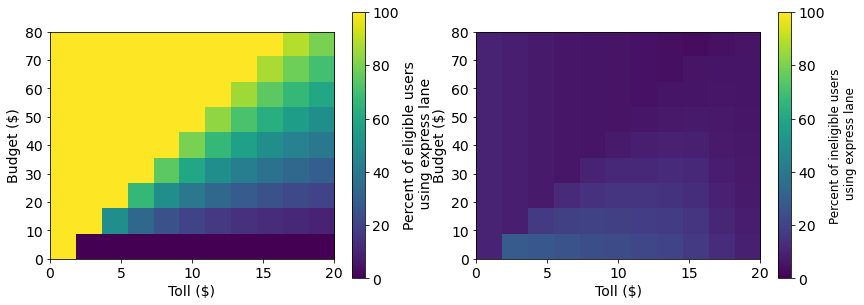

In [151]:
###### Fractions of users on the express lane ######
side_by_side_figs(x_plot,y_plot,[100*exp_el_budget.T, 100*exp_in_budget.T],'Toll ($)','Budget ($)',
                  ["Percent of eligible users\n using express lane","Percent of ineligible users\n using express lane"],
                  'ExpressSharesELIN_2d',dimensions='2df',textSize=14)
# side_by_side_figs(x_plot,y_plot,[100*exp_el_budget.T],'Toll ($)','Budget ($)',
#                   ["Percent of eligible users\n using express lane"],'ExpressSharesEL_2d',dimensions='2df',textSize=20)
# side_by_side_figs(x_plot,y_plot,[100*exp_in_budget.T],'Toll ($)','Budget ($)',
#                   ["Percent of ineligible users\n using express lane"],'ExpressSharesIN_2d',dimensions='2df',textSize=20)
# side_by_side_figs(x_plot,y_plot,[100*exp_all_budget.T],'Toll ($)','Budget ($)',
#                   ["Percent of all users\n using express lane"],'ExpressShareAll_2d',dimensions='2df',textSize=20)

In [152]:
# share_inel_all_budget
# exp_in_p_budget

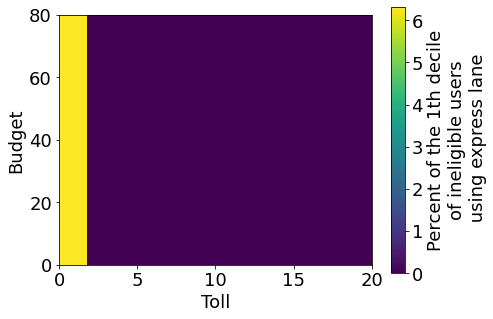

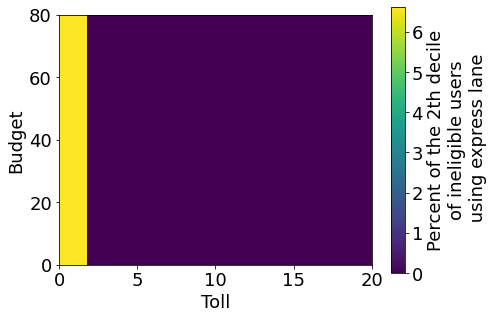

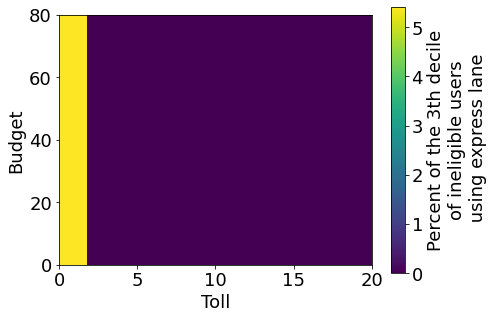

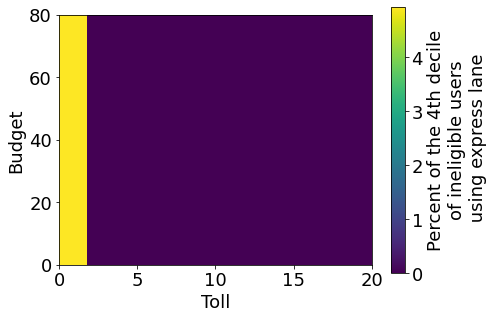

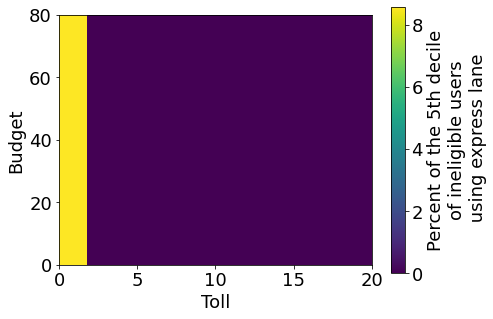

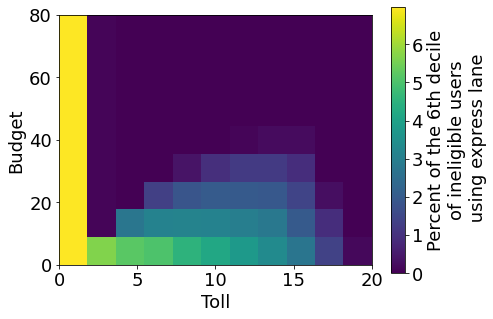

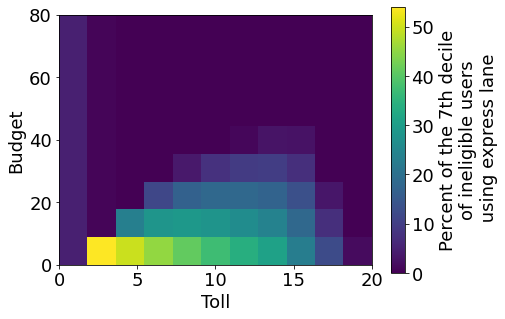

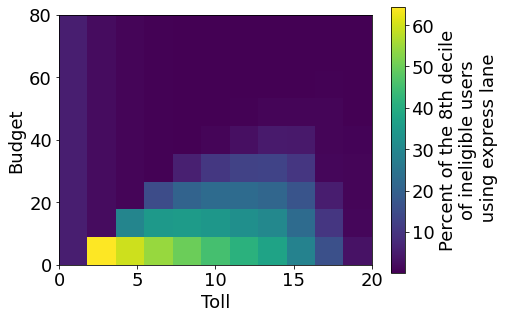

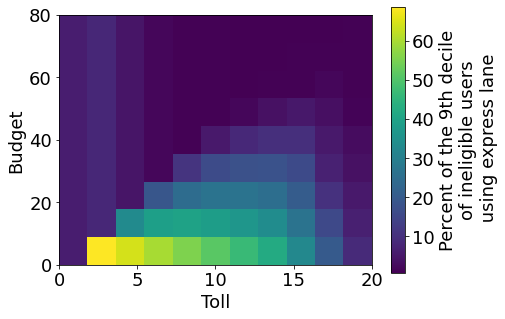

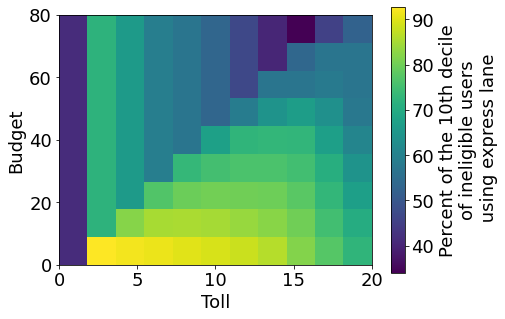

In [153]:
###### Fractions of ineligible users on the express lane by decile ######
for p in range(1,11):
    side_by_side_figs(x_plot,y_plot,[100*exp_in_p_budget[10*p].T],'Toll','Budget',
                  ["Percent of the {}th decile\nof ineligible users\n using express lane".format(p)],'ExpressSharesINP{}_2d'.format(p),dimensions='2df')

In [154]:
# print(avg_tt_budget)
# print()
# print(avg_EL_tt_budget)
# print()
# print(avg_GP_tt_budget)

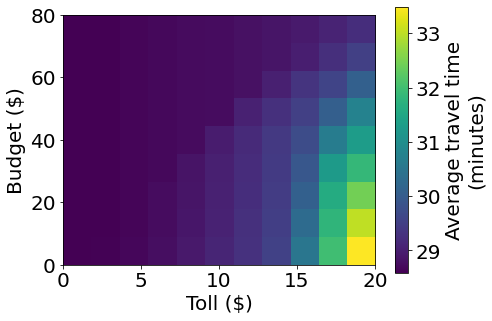

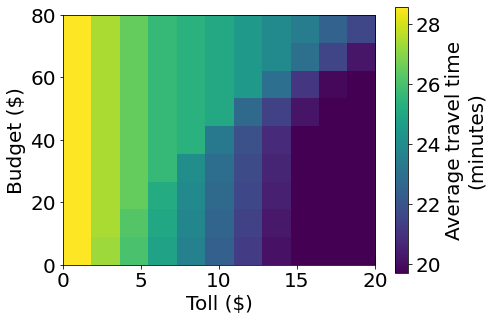

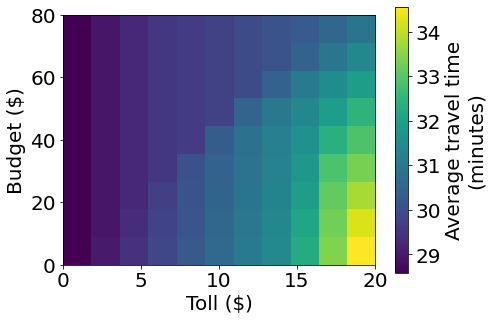

In [155]:
###### Average travel times ######
side_by_side_figs(x_plot,y_plot,[avg_tt_budget.T],'Toll ($)','Budget ($)',
                  ["Average travel time\n(minutes)"],'Avg_TravelTime_2d',dimensions='2df',textSize=20)
side_by_side_figs(x_plot,y_plot,[avg_EL_tt_budget.T],'Toll ($)','Budget ($)',
                  ["Average travel time\n(minutes)"],'AvgTravelTimesE_2d',dimensions='2df',textSize=20)
side_by_side_figs(x_plot,y_plot,[avg_GP_tt_budget.T],'Toll ($)','Budget ($)',
                  ["Average travel time\n(minutes)"],'AvgTravelTimesNE_2d',dimensions='2df',textSize=20)

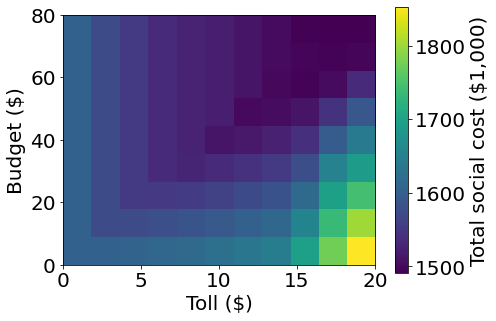

In [156]:
###### Pareto-weighted objective functions ######
weight_e = 35
weight_i = 1
weight_t = 1
z_labels={"1_0_0":"Total travel cost ($1,000)\nEligible users",
         "0_1_0":"Total travel cost ($1,000)\nIneligible users",
         "0_0_1":"Negative total toll revenue\n($1,000)",
         "1_1_1":"Total social cost ($1,000)",
         "5_1_1":"Total social cost ($1,000)",
          "10_1_1":"Total social cost ($1,000)",
         "11_1_1":"Total social cost ($1,000)",
         "12_1_1":"Total social cost ($1,000)",
         "15_1_1":"Total social cost ($1,000)","35_1_1":"Total social cost ($1,000)"}
side_by_side_figs(x_plot,y_plot,[((weight_i*total_tc_in_budget.T)+(weight_e*total_tc_el_budget.T)-(weight_t*total_tr_budget.T))/1000],
                  'Toll ($)','Budget ($)',[z_labels["{}_{}_{}".format(weight_e,weight_i,weight_t)]],
                  'Total SWEL{}IN{}_TR{}_2d'.format(weight_e,weight_i,weight_t),dimensions='2df',textSize=20)

In [157]:
###### Compute optimal CBCP & metrics for various weigthing schemes ######
t_ix=0
b_ix=0
t=int(tau_arr[t_ix])
b=int(B_arr[b_ix])
weight_e = 1
weight_i = 1
weight_t = 1

this_df = []

for weight_e in range(21):
    for i in range(len(tau_arr)):
        this_row={'weight_e':weight_e,'weight_i':weight_i,'weight_t':weight_t}
        this=np.where(((weight_i*total_tc_in_budget[i])+(weight_e*total_tc_el_budget[i])-(weight_t*total_tr_budget[i]))==np.min(
                        ((weight_i*total_tc_in_budget)+(weight_e*total_tc_el_budget)-(weight_t*total_tr_budget))))[0]
        t=int(tau_arr[i])
        if len(this)>0:
            b=int(B_arr[this[0]])
            this_row['toll']=t
            this_row['budget']=b
            t_ix=i
            b_ix=this[0]
            this_row['ExpShare_All']=np.round(100*exp_all_budget[t_ix,b_ix],0)
            this_row['ExpShare_El']=np.round(100*exp_el_budget[t_ix,b_ix],0)
            this_row['ExpShare_In']=np.round(100*exp_in_budget[t_ix,b_ix],0)
            this_row['TotalGenCost_All']=np.round((total_tc_in_budget[t_ix,b_ix]+total_tc_el_budget[t_ix,b_ix]+total_tr_budget[t_ix,b_ix]),2)
            this_row['TotalGenCost_El']=np.round(total_tc_el_budget[t_ix,b_ix],2)
            this_row['TotalGenCost_In']=np.round(total_tc_in_budget[t_ix,b_ix],2)
            this_row['TotalTR']=np.round(total_tr_budget[t_ix,b_ix],2)
            this_row['AvgTT_Express']=np.round(avg_EL_tt_budget[t_ix,b_ix],1)
            this_row['AvgTT_GP']=np.round(avg_GP_tt_budget[t_ix,b_ix],1)
            this_df.append(this_row)
            
for s in [[1,0,0],[0,1,0],[0,0,1]]:
    weight_e = s[0]
    weight_i = s[1]
    weight_t = s[2]
    for i in range(len(tau_arr)):
        this_row={'weight_e':weight_e,'weight_i':weight_i,'weight_t':weight_t}
        this=np.where(((weight_i*total_tc_in_budget[i])+(weight_e*total_tc_el_budget[i])-(weight_t*total_tr_budget[i]))==np.min(
                        ((weight_i*total_tc_in_budget)+(weight_e*total_tc_el_budget)-(weight_t*total_tr_budget))))[0]
        t=int(tau_arr[i])
        if len(this)>0:
            b=int(B_arr[this[0]])
            this_row['toll']=t
            this_row['budget']=b
            t_ix=i
            b_ix=this[0]
            this_row['ExpShare_All']=np.round(100*exp_all_budget[t_ix,b_ix],0)
            this_row['ExpShare_El']=np.round(100*exp_el_budget[t_ix,b_ix],0)
            this_row['ExpShare_In']=np.round(100*exp_in_budget[t_ix,b_ix],0)
            this_row['TotalGenCost_All']=np.round((total_tc_in_budget[t_ix,b_ix]+total_tc_el_budget[t_ix,b_ix]+total_tr_budget[t_ix,b_ix]),2)
            this_row['TotalGenCost_El']=np.round(total_tc_el_budget[t_ix,b_ix],2)
            this_row['TotalGenCost_In']=np.round(total_tc_in_budget[t_ix,b_ix],2)
            this_row['TotalTR']=np.round(total_tr_budget[t_ix,b_ix],2)
            this_row['AvgTT_Express']=np.round(avg_EL_tt_budget[t_ix,b_ix],1)
            this_row['AvgTT_GP']=np.round(avg_GP_tt_budget[t_ix,b_ix],1)
            this_df.append(this_row)

this_df=pd.DataFrame.from_records(this_df)
this_df

,weight_e,weight_i,weight_t,toll,budget,ExpShare_All,ExpShare_El,ExpShare_In,TotalGenCost_All,TotalGenCost_El,TotalGenCost_In,TotalTR,AvgTT_Express,AvgTT_GP
0,0,1,1,12,0,18.0,0.0,21.0,980683.98,24212.70,871350.06,85121.22,21.3,31.0
1,1,1,1,12,0,18.0,0.0,21.0,980683.98,24212.70,871350.06,85121.22,21.3,31.0
2,2,1,1,12,0,18.0,0.0,21.0,980683.98,24212.70,871350.06,85121.22,21.3,31.0
3,3,1,1,12,0,18.0,0.0,21.0,980683.98,24212.70,871350.06,85121.22,21.3,31.0
4,4,1,1,10,0,19.0,0.0,23.0,962343.25,23912.68,862906.10,75524.47,22.4,30.6
5,5,1,1,10,0,19.0,0.0,23.0,962343.25,23912.68,862906.10,75524.47,22.4,30.6
6,6,1,1,10,0,19.0,0.0,23.0,962343.25,23912.68,862906.10,75524.47,22.4,30.6
7,7,1,1,10,0,19.0,0.0,23.0,962343.25,23912.68,862906.10,75524.47,22.4,30.6
8,8,1,1,10,0,19.0,0.0,23.0,962343.25,23912.68,862906.10,75524.47,22.4,30.6
9,9,1,1,10,0,19.0,0.0,23.0,962343.25,23912.68,862906.10,75524.47,22.4,30.6


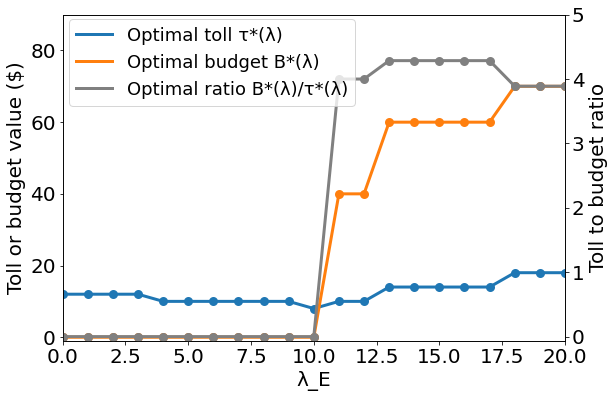

In [158]:
###### Plot optimal CBCP parameters with respect to weigthing scheme ######

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].toll,linewidth=3,label='Optimal toll τ*(λ)')
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].budget,linewidth=3,label='Optimal budget B*(λ)')
ax2.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].budget/this_df.iloc[:21].toll,linewidth=3,label='Optimal ratio B*(λ)/τ*(λ)',color='grey')
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].toll,linewidth=3)
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].budget,linewidth=3)
ax2.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].budget/this_df.iloc[:21].toll,linewidth=3,color='grey')

ax1.set_xlabel("λ_E")
ax1.set_ylabel("Toll or budget value ($)")
ax2.set_ylabel('Toll to budget ratio')
fig.legend(bbox_to_anchor=(0.09, 0.02, 0.5, 0.87),fontsize=18)
fig.set_size_inches(9, 6)
ax1.xaxis.label.set_fontsize(20)
ax1.yaxis.label.set_fontsize(20)
ax2.yaxis.label.set_fontsize(20)
ax1.set(xlim=(0,20), ylim=(-1, 90))
ax2.set(xlim=(0,20), ylim=(-0.065, 5))
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels()):
    label.set_fontsize(20)
fig.savefig('OptTollBudget_weight_E.png',bbox_inches='tight')


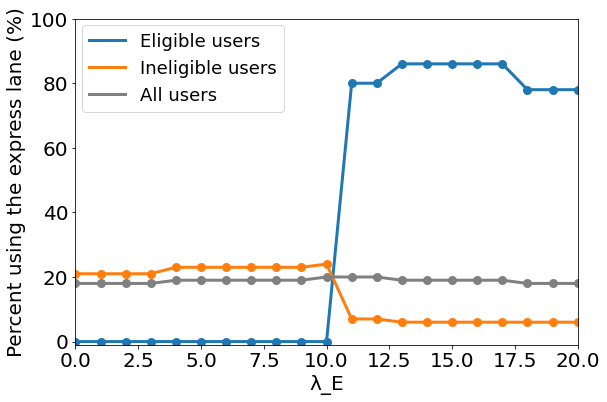

In [159]:
###### Plot optimal CBCP EL usage rates with respect to weigthing scheme ######

fig, ax1 = plt.subplots()

ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_El,linewidth=3,label='Eligible users')
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_In,linewidth=3,label='Ineligible users')
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_All,linewidth=3,label='All users',color='grey')
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_El,linewidth=3)
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_In,linewidth=3)
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_All,linewidth=3,color='grey')
ax1.set_xlabel("λ_E")
ax1.set_ylabel("Percent using the express lane (%)")
fig.legend(bbox_to_anchor=(-0.04, 0.015, 0.5, 0.87),fontsize=18)
fig.set_size_inches(9, 6)
ax1.xaxis.label.set_fontsize(20)
ax1.yaxis.label.set_fontsize(20)
ax1.set(xlim=(0,20), ylim=(-1, 100))

for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(20)
fig.savefig('OptUserShares_weight_E.png',bbox_inches='tight')

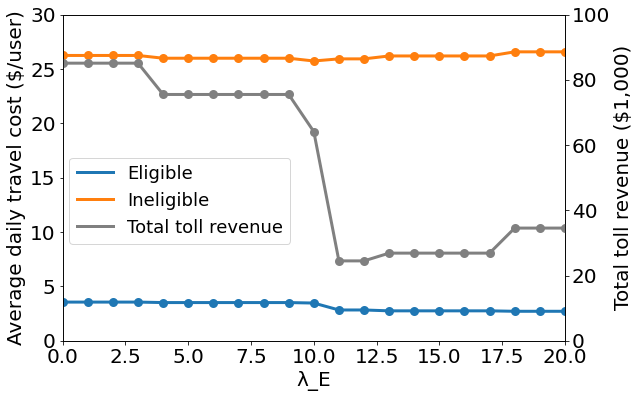

In [160]:
###### Plot optimal CBCP travel cost metrics with respect to weigthing scheme ######

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalGenCost_El/(num_eligible*T),linewidth=3,label='Eligible')
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalGenCost_In/(T*num_ineligible),linewidth=3,label='Ineligible')
ax2.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalTR/1000,linewidth=3,label='Total toll revenue',color='grey')
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalGenCost_El/(T*num_eligible),linewidth=3)
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalGenCost_In/(T*num_ineligible),linewidth=3)
ax2.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalTR/1000,linewidth=3,color='grey')
ax1.set_xlabel("λ_E")
ax1.set_ylabel("Average daily travel cost ($/user)")
ax2.set_ylabel('Total toll revenue ($1,000)')
fig.legend(bbox_to_anchor=(-0.01, -0.3, 0.5, 0.87),fontsize=18)
fig.set_size_inches(9, 6)
ax1.xaxis.label.set_fontsize(20)
ax1.yaxis.label.set_fontsize(20)
ax2.yaxis.label.set_fontsize(20)
ax1.set(xlim=(0,20), ylim=(0, 30))
ax2.set(xlim=(0,20), ylim=(0, 100))
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()+ ax2.get_yticklabels()):
    label.set_fontsize(20) 
fig.savefig('OptSocialCosts_weight_E.png',bbox_inches='tight')


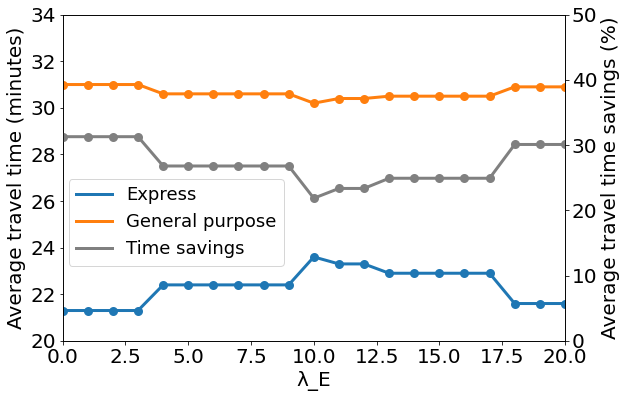

In [161]:


###### Plot optimal CBCP travel times with respect to weigthing scheme ######

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].AvgTT_Express,linewidth=3,label='Express')
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].AvgTT_GP,linewidth=3,label='General purpose')
ax2.plot(this_df.iloc[:21].weight_e,100*(this_df.iloc[:21].AvgTT_GP-this_df.iloc[:21].AvgTT_Express)/this_df.iloc[:21].AvgTT_GP,linewidth=3,label='Time savings',color='grey')
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].AvgTT_Express,linewidth=3)
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].AvgTT_GP,linewidth=3)
ax2.scatter(this_df.iloc[:21].weight_e,100*(this_df.iloc[:21].AvgTT_GP-this_df.iloc[:21].AvgTT_Express)/this_df.iloc[:21].AvgTT_GP,linewidth=3,color='grey')

ax1.set_xlabel("λ_E")
ax1.set_ylabel("Average travel time (minutes)")
ax2.set_ylabel('Average travel time savings (%)')
fig.legend(bbox_to_anchor=(-0.02, -0.35, 0.5, 0.87),fontsize=18)
fig.set_size_inches(9, 6)
ax1.xaxis.label.set_fontsize(20)
ax1.yaxis.label.set_fontsize(20)
ax2.yaxis.label.set_fontsize(20)
ax1.set(xlim=(0,20), ylim=(20, 34))
ax2.set(xlim=(0,20), ylim=(0, 50))
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()+ ax2.get_yticklabels()):
    label.set_fontsize(20)
fig.savefig('OptTravelTimes_weight_E.png',bbox_inches='tight')



# Scratch Work:

In [ ]:
# 20*np.linspace(0, 1, 21)[0:]
# np.linspace(toll_arr[0], toll_arr[-3]*T,19)